In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, display_html, display_markdown, HTML, Markdown as md
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import math
from scipy import stats
import pickle
from joblib import dump, load
import time

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [2]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=DM+Sans:ital,opsz,wght@0,9..40,100..1000;1,9..40,100..1000&display=swap');
div.text_cell {font-family : DM Sans, sans-serif !important;}
pre {font-family : DM Sans, sans-serif !important;}
</style>

# **Regression Model Comparison Template** 
This Notebook compares the performance of different types of regression models on a dataset provided by the user. It is meant to assist in the model selection process by helping users discern the most suitible regression model for their dataset. Throughout the template there are global variables that the user must configure which represent characteristics of the dataset. Unchanging characteristics like the name of the data file are represented with capitalized constant variables. Users should store data in the data directory.
## **Regression Analysis**
Regression refers to statistical methods for analyzing the relationship between dependent and independent variables. In machine learning, regression analysis is implimented as supervised learning algorithms used to identify the relationships between dependent variables called targets and predictive independent variables called features. 

In this example, the regression models are evaluated on a kaggle dataset that contains 10 columns which describe characteristics of diamonds, such as their cut, color, clarity, and dimensions. The target variable is the price of the diamond.

## **Load in a Dataset and Select Columns to Drop**

In [274]:
DATA_FILE_NAME: str = "regression_diamond_data.csv" 
COLUMNS_TO_DROP: list[str] = ["id"] 


def display_dataframe(df: pd.DataFrame, font_size: int = 20) -> None:
    """
    Displays the passed in DataFrame with the specified font size.

    Args:
        df (pd.DataFrame): The DataFrame to be displayed.
        font_size (int): The font size at which the DataFrame should be displayed.

    Returns:
        None
    """
    # Convert the DataFrame to HTML
    df_html = df.to_html()
    # Apply the font size directly to the HTML
    styled_html = f'<div style="font-size: {font_size}px;">{df_html}</div>'
    display_html(HTML(styled_html))
    

def display_text(text: str, font_size: int = 16, font_weight: str = 'normal') -> None:
    """
    Displays the passed in text with the specified font size and font weight.

    Args:
        text (str): The text to be displayed.
        font_size (int): The font size at which the text should be displayed.
        font_weight (str): The font weight (e.g., 'normal', 'bold', 'bolder', 'lighter', or numeric value from 100 to 900).

    Returns:
        None
    """
    # Apply the font size and font weight directly to the HTML
    styled_html = f'<div style="font-size: {font_size}px; font-weight: {font_weight};">{text}</div>'
    display_html(HTML(styled_html))
    

def load_data(file_name: str = DATA_FILE_NAME, dropped_columns = COLUMNS_TO_DROP) -> pd.DataFrame:
    """
    Loads in user's input file as a pandas DataFrame.
    
    Args:
        file_name (str): Name of file containing data for clustering
        dropped_columns (list[str]): List of columns to drop from the dataframe
    Returns:
        pd.DataFrame: Dataframe of variable values for all data entries
    """
    
    file_name = "data/" + file_name
    file_extension = file_name.split(".")[-1]

    if file_extension == "csv":
        df = pd.read_csv(file_name)
    elif file_extension in ["xls", "xlsx"]:
        df = pd.read_excel(file_name)
    elif file_extension == "json":
        df = pd.read_json(file_name)
    else:
        raise ValueError("Unsupported file format or misspelled file name. Please upload a CSV, Excel, or JSON file and ensure the file name is spelled correctly.")
    
    df.drop_duplicates(inplace = True)
    df.drop(columns = dropped_columns, inplace = True)
    
    return df

data_df = load_data()
initial_number_of_entries, number_of_variables = data_df.shape
display_text(f"Initial Number of Entries: {initial_number_of_entries}", font_size = 18)
display_text(f"Number of Variables: {number_of_variables}", font_size = 18)
display_dataframe(data_df.head(), font_size = 20)


Initial Number of Entries: 53940

Number of Variables: 10

carat 
 cut 
 color 
 clarity 
 depth 
 table 
 price 
 x 
 y 
 z 
 
 
 
 
 0 
 0.23 
 Ideal 
 E 
 SI2 
 61.5 
 55.0 
 326 
 3.95 
 3.98 
 2.43 
 
 
 1 
 0.21 
 Premium 
 E 
 SI1 
 59.8 
 61.0 
 326 
 3.89 
 3.84 
 2.31 
 
 
 2 
 0.23 
 Good 
 E 
 VS1 
 56.9 
 65.0 
 327 
 4.05 
 4.07 
 2.31 
 
 
 3 
 0.29 
 Premium 
 I 
 VS2 
 62.4 
 58.0 
 334 
 4.20 
 4.23 
 2.63 
 
 
 4 
 0.31 
 Good 
 J 
 SI2 
 63.3 
 58.0 
 335 
 4.34 
 4.35 
 2.75

### **Dataset Missing Values Information**

In [275]:
numerical_columns: list[str] = list(data_df.select_dtypes(include = np.number).columns)
display_markdown(md(f"### **Numerical Variables:** {numerical_columns}"))

categorical_columns: list[str] = list(data_df.select_dtypes(exclude = np.number).columns)
display_markdown(md(f"### **Categorical Variables:** {categorical_columns}"))

# Automatically select columns with missing values
numerical_columns_with_missing_values: list[str] = data_df[numerical_columns].columns[data_df[numerical_columns].isnull().any()].tolist()
categorical_columns_with_missing_values: list[str] = data_df[categorical_columns].columns[data_df[categorical_columns].isnull().any()].tolist()


def display_missing_values_information(df: pd.DataFrame = data_df,
                                       numerical_columns: list[str] = numerical_columns_with_missing_values,
                                       categorical_columns: list[str] = categorical_columns_with_missing_values,
                                       number_of_entries: int = initial_number_of_entries,
                                       show_missing_type: bool = False) -> None:
    """Display detailed information about missing values in a DataFrame.

    This function provides a comprehensive summary of missing values in a DataFrame, including the number and
    percentage of missing values for each column, the type of missing values (if specified), and a preview of 
    entries with missing values. It also computes the total number of entries and entries with missing values,
    along with the impact of dropping rows with missing values.

    Args:
        df (pd.DataFrame): The DataFrame to analyze for missing values. Defaults to `data_df`.
        numerical_columns (list[str]): List of numerical columns to check for missing values. Defaults to `numerical_columns_with_missing_values`.
        categorical_columns (list[str]): List of categorical columns to check for missing values. Defaults to `categorical_columns_with_missing_values`.
        number_of_entries (int): The initial number of entries in the DataFrame. Defaults to `initial_number_of_entries`.
        show_missing_type (bool): If True, displays the type of missing values (either `np.nan` or `None`). Defaults to `False`.

    Returns:
        None
    """
    columns_with_missing_values: list[str] = numerical_columns + categorical_columns
    
    if len(columns_with_missing_values) != 0:
        print()
        
        if show_missing_type:
            # The next two if statements show the missing value type for each column with missing values,
            # a necessary argument for imputation functions. Only works if missing value is either np.nan or None.
            if len(categorical_columns_with_missing_values) != 0:    
                display_markdown(md(f"### **Missing Value Type for Categorical Variables with Missing Values (either np.nan or None)**"))
                
                for column in categorical_columns_with_missing_values:
                    missing_values = df[column][df[column].isnull()]
                    missing_type = type(missing_values.iloc[0])
                    
                    if pd.isna(missing_values.iloc[0]):
                        display_markdown(md(f"* #### **{column}**: np.nan"))
                    else:
                        display_markdown(md(f"* #### **{column}**: {str(missing_type)}"))
            
            if len(numerical_columns_with_missing_values) != 0:
                display_markdown(md(f"### **Missing Value Type for Numerical Variables with Missing Values (either np.nan or None)**"))
                
                for column in categorical_columns_with_missing_values:
                    missing_values = df[column][df[column].isnull()]
                    missing_type = type(missing_values.iloc[0])
                    
                    if pd.isna(missing_values.iloc[0]):
                        display_markdown(md(f"* #### **{column}**: np.nan"))
                    else:
                        display_markdown(md(f"* #### **{column}**: {str(missing_type)}"))
                    
        
        print()
        entries_with_missing_values_df: pd.DataFrame = df[columns_with_missing_values][df[columns_with_missing_values].isnull().any(axis = "columns")]
        number_of_entries_with_missing_values: int = len(entries_with_missing_values_df)
        percent_of_entries_with_missing_values: float = (number_of_entries_with_missing_values / number_of_entries) * 100
        total_number_of_missing_values: int = df[columns_with_missing_values].isnull().sum().sum()
        
        display_markdown(md(f"### **Missing Values by Variable**"))
        
        for column in columns_with_missing_values:
            column_missing_values: int = df[column].isnull().sum()
            percent_missing_values: float = (column_missing_values / number_of_entries) * 100
            
            if column_missing_values != 0:
                display_markdown(md(f"* #### **{column}**: {column_missing_values} ({percent_missing_values:.2f}% of Entries)"))
            
        print()
        display_markdown(md(f"### **Total Number of Entries:** {number_of_entries}"))
        display_markdown(md(f"### **Total Number of Entreis with at Least One Missing Value:** {number_of_entries_with_missing_values} ({percent_of_entries_with_missing_values:.2f}% of Entries)"))
        display_markdown(md(f"### **Number of Entries if all Rows with Missing Values are Dropped:** {number_of_entries - number_of_entries_with_missing_values}"))
        display_markdown(md(f"### **Total Number of Missing Values:** {total_number_of_missing_values}"))
        print()
        display_markdown(md("### Up to First 5 Entries with Missing Values"))
        display_dataframe(entries_with_missing_values_df.head(), font_size = 20)
    else:
        print()
        display_markdown(md("### **No Missing Values in Dataset**"))
        

display_missing_values_information()

### **Numerical Variables:** ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

### **Categorical Variables:** ['cut', 'color', 'clarity']

### **No Missing Values in Dataset**

## **Handle Missing Values**
#### Chose between dropping or imputing missing values. 
#### If you chose to impute missing values, edit the imputute_missing_values function to suite your use case (such as choosing columns to impute and specifying between imputing with the mean, median, or mode of the column). The given imputute_missing_values function is applied to all columns with missing values. Missing numerical values are imputed with the median of the column and missing categorical values are imputed with the mode of the column.

In [251]:
def drop_rows_with_missing_values(df: pd.DataFrame = data_df) -> pd.DataFrame:
    """
    Drops all rows with missing values from the DataFrame and splits dataset into feature dataframe and target series.
    Also prints number of entries of returned feature dataframe and target series to ensure they are equal.
    
    Args:
        df (pd.DataFrame): DataFrame containing loded in data
        target_variable_comlumn (str): Name of the target variable column
    Returns:
        pd.DataFrame: DataFrame with missing values dropped
    """
    
    original_number_of_entries = len(df)
    dropna_df = df.dropna()
    new_number_of_entries = len(dropna_df)
    number_of_entries_dropped = original_number_of_entries - new_number_of_entries
    
    display_markdown(md(f"### drop_rows_with_missing_values Results: {number_of_entries_dropped} Entries Dropped"))
    display_markdown(md(f"### New Number of Entries: {new_number_of_entries}"))
    
    return dropna_df


def impute_missing_values(df: pd.DataFrame = data_df,
                          numerical_columns_to_impute: list[str] = numerical_columns_with_missing_values,
                          categorical_columns_to_impute: list[str] = categorical_columns_with_missing_values) -> pd.DataFrame:
    """
    Imputes missing values in the DataFrame with either the median value (for numerical features) or the most frequent value (for categorical features)
    and splits dataset into feature dataframe and target series. Also prints number of entries of returned feature dataframe and target series to ensure they are equal.
    
    Args:
        df (pd.DataFrame): DataFrame containing loded in data.
        target_variable_column (str): Name of the target variable column
    Returns:
        impute_df (pd.DataFrame): DataFrame with missing values imputed
    """
    impute_df = df.copy()
    
    numerical_imputer = SimpleImputer(strategy = "median")
    categorical_imputer = SimpleImputer(strategy = "most_frequent")
    
    impute_df[numerical_columns_to_impute] = numerical_imputer.fit_transform(impute_df[numerical_columns_to_impute])
    impute_df[categorical_columns_to_impute] = categorical_imputer.fit_transform(impute_df[categorical_columns_to_impute])
    
    display_markdown(md("### Missing Values Imputed"))
    
    return impute_df


dropna_data_df = drop_rows_with_missing_values()

### drop_rows_with_missing_values Results: 0 Entries Dropped

### New Number of Entries: 53940

## **Handle Outliers/Eronious Entries**

Numerical Variables Information

carat 
 depth 
 table 
 price 
 x 
 y 
 z 
 
 
 
 
 count 
 53940.000000 
 53940.000000 
 53940.000000 
 53940.000000 
 53940.000000 
 53940.000000 
 53940.000000 
 
 
 mean 
 0.797940 
 61.749405 
 57.457184 
 3932.799722 
 5.731157 
 5.734526 
 3.538734 
 
 
 std 
 0.474011 
 1.432621 
 2.234491 
 3989.439738 
 1.121761 
 1.142135 
 0.705699 
 
 
 min 
 0.200000 
 43.000000 
 43.000000 
 326.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 25% 
 0.400000 
 61.000000 
 56.000000 
 950.000000 
 4.710000 
 4.720000 
 2.910000 
 
 
 50% 
 0.700000 
 61.800000 
 57.000000 
 2401.000000 
 5.700000 
 5.710000 
 3.530000 
 
 
 75% 
 1.040000 
 62.500000 
 59.000000 
 5324.250000 
 6.540000 
 6.540000 
 4.040000 
 
 
 max 
 5.010000 
 79.000000 
 95.000000 
 18823.000000 
 10.740000 
 58.900000 
 31.800000

Total Number of Outlier Entries Removed in x: 8

Total Number of Outlier Entries Removed in y: 2

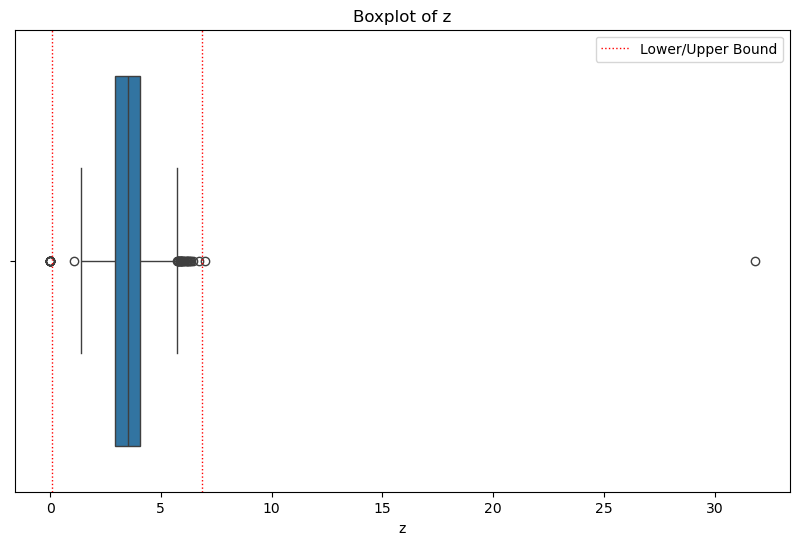

z:

- Lower Bound for Outliers: 0.08500000000000041

- Upper Bound for Outliers: 6.865

- Number of Outliers Below Lower Bound: 12

- Number of Outliers Above Upper Bound: 2

Total Number of Outlier Entries Removed in z: 12

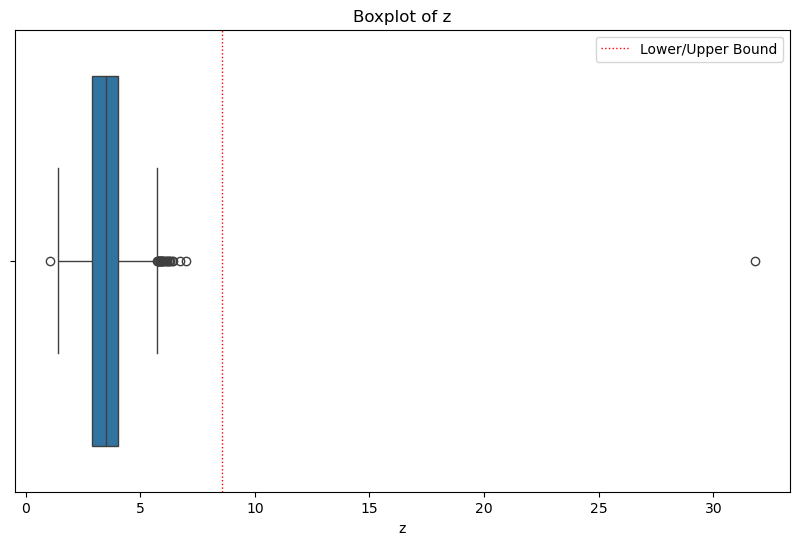

z:

- Lower Bound for Outliers: -1.6099999999999994

- Upper Bound for Outliers: 8.559999999999999

- Number of Outliers Below Lower Bound: 0

- Number of Outliers Above Upper Bound: 1

Total Number of Outlier Entries Removed in z: 1

Updated Numerical Variables Information

carat 
 depth 
 table 
 price 
 x 
 y 
 z 
 
 
 
 
 count 
 53917.000000 
 53917.000000 
 53917.000000 
 53917.000000 
 53917.000000 
 53917.000000 
 53917.000000 
 
 
 mean 
 0.797687 
 61.749565 
 57.456939 
 3930.910474 
 5.731605 
 5.733428 
 3.539409 
 
 
 std 
 0.473777 
 1.432318 
 2.234069 
 3987.215003 
 1.119402 
 1.111272 
 0.691620 
 
 
 min 
 0.200000 
 43.000000 
 43.000000 
 326.000000 
 3.730000 
 3.680000 
 1.070000 
 
 
 25% 
 0.400000 
 61.000000 
 56.000000 
 949.000000 
 4.710000 
 4.720000 
 2.910000 
 
 
 50% 
 0.700000 
 61.800000 
 57.000000 
 2401.000000 
 5.700000 
 5.710000 
 3.530000 
 
 
 75% 
 1.040000 
 62.500000 
 59.000000 
 5323.000000 
 6.540000 
 6.540000 
 4.040000 
 
 
 max 
 5.010000 
 79.000000 
 95.000000 
 18823.000000 
 10.740000 
 10.540000 
 6.980000

In [254]:
display_text("Numerical Variables Information", font_size = 22, font_weight = 'bold')
display_dataframe(dropna_data_df.describe(), 16) 
print()


def visualize_outliers(df: pd.DataFrame,
                       columns_to_check: list[str] = None,
                       iqr_multiplier: float = 1.5,
                       remove: bool = False,
                       remove_option: str = 'both',
                       display: bool = True,) -> pd.DataFrame:
    """
    Visualizes outliers in each numerical column of the DataFrame using boxplots and optionally removes them.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        iqr_multiplier (float): Multiplier for the interquartile range to define outliers
        columns_to_check (list[str]): List of columns to check for outliers. If None, all numerical columns will be checked.
        remove (bool): If True, returns a DataFrame with outliers removed.
        remove_option (str): Option to remove 'both', 'upper', or 'lower' outliers.
        display (bool): If True, displays boxplots of each column with outliers and their lower and upper bounds.
    
    Returns:
        pd.DataFrame: DataFrame with outliers removed if remove is True, otherwise the original DataFrame
    """
    if columns_to_check is None:
        columns_to_check = df.select_dtypes(include=[np.number]).columns
    else:
        columns_to_check = [col for col in columns_to_check if (col in df.columns)]
    
    outlier_indices = set()
    
    for col in columns_to_check:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - iqr_multiplier * iqr
        upper_bound = q3 + iqr_multiplier * iqr
        
        if display:
            plt.figure(figsize=(10, 6))
            ax = sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col}')
            
            # Add vertical red dotted lines for lower and upper bounds if within the plot's x-axis limits
            x_min, x_max = ax.get_xlim()
            if x_min <= lower_bound <= x_max:
                plt.axvline(lower_bound, color='red', linestyle='dotted', linewidth=1)
            if x_min <= upper_bound <= x_max:
                plt.axvline(upper_bound, color='red', linestyle='dotted', linewidth=1)
            
            # Create legend
            legend_lines = [Line2D([0], [0], color='red', linestyle='dotted', linewidth=1)]
            legend_labels = ['Lower/Upper Bound']
            plt.legend(legend_lines, legend_labels, loc='upper right')
            
            plt.show()
        
            display_text(f"{col}:", font_size = 18, font_weight = 'bold')
            display_text(f"- Lower Bound for Outliers: {lower_bound}", font_size = 16)
            display_text(f"- Upper Bound for Outliers: {upper_bound}", font_size = 16)
            display_text(f"- Number of Outliers Below Lower Bound: {df[col][df[col] < lower_bound].count()}", font_size = 16)
            display_text(f"- Number of Outliers Above Upper Bound: {df[col][df[col] > upper_bound].count()}", font_size = 16)
            print()
        
        
        if remove_option in ['both', 'lower']:
            outlier_indices.update(df.index[df[col] < lower_bound].tolist())
        if remove_option in ['both', 'upper']:
            outlier_indices.update(df.index[df[col] > upper_bound].tolist())
    
    if remove:
        df_cleaned = df.drop(index=outlier_indices)
        display_text(f"Total Number of Outlier Entries Removed in {col}: {(len(outlier_indices))}", font_size = 18)
        print()
        return df_cleaned
    
    return df
    

removed_outliers_df = visualize_outliers(dropna_data_df, ["x"], iqr_multiplier = 2.5, remove = True, display = False)
removed_outliers_df = visualize_outliers(removed_outliers_df, ["y"], iqr_multiplier = 2.5, remove = True, display = False)
removed_outliers_df = visualize_outliers(removed_outliers_df, ["z"], iqr_multiplier = 2.5, remove = True, remove_option = 'lower')
removed_outliers_df = visualize_outliers(removed_outliers_df, ["z"], iqr_multiplier = 4, remove = True, remove_option = 'upper')

display_text("Updated Numerical Variables Information", font_size = 22, font_weight = 'bold')
display_dataframe(removed_outliers_df.describe(), 16) 

## **Setup Preprocessing**

### **Dataset Preprocessing Information**
#### Displays information that helps users setup their preprocessing steps.

In [276]:
display_markdown(md(f"### **Numerical Columns:** {numerical_columns}"))
display_markdown(md(f"### **Categorical Columns:** {categorical_columns}"))

if len(categorical_columns) != 0:
    print()
    display_markdown(md("### **Unique Entries for Categorical Columns**"))
    
    for column in categorical_columns:
        unique_entries = list(data_df[column].unique())
        display_markdown(md(f"* #### **{column}** Column: {unique_entries}"))

display_dataframe(data_df.head())

### **Numerical Columns:** ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

### **Categorical Columns:** ['cut', 'color', 'clarity']

### **Unique Entries for Categorical Columns**

* #### **cut** Column: ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']

* #### **color** Column: ['E', 'I', 'J', 'H', 'F', 'G', 'D']

* #### **clarity** Column: ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']

carat 
 cut 
 color 
 clarity 
 depth 
 table 
 price 
 x 
 y 
 z 
 
 
 
 
 0 
 0.23 
 Ideal 
 E 
 SI2 
 61.5 
 55.0 
 326 
 3.95 
 3.98 
 2.43 
 
 
 1 
 0.21 
 Premium 
 E 
 SI1 
 59.8 
 61.0 
 326 
 3.89 
 3.84 
 2.31 
 
 
 2 
 0.23 
 Good 
 E 
 VS1 
 56.9 
 65.0 
 327 
 4.05 
 4.07 
 2.31 
 
 
 3 
 0.29 
 Premium 
 I 
 VS2 
 62.4 
 58.0 
 334 
 4.20 
 4.23 
 2.63 
 
 
 4 
 0.31 
 Good 
 J 
 SI2 
 63.3 
 58.0 
 335 
 4.34 
 4.35 
 2.75

### **Preprocessing Steps**
#### Edit the preprocessing steps to suit your dataset. The preprocessing steps for the feature dataframe are composed with the make_pipeline function to load in models, so combine them with a function such as ColumnTransformer to create a single preprocessing variable.
#### Preprocessing for the target series must be done separately from the feature dataframe. The target preprocessing steps will be applied directly to the y_train and y_test sets when splits are created.

In [256]:
TARGET_COLUMN_NAME: str = "price"


numerical_features_to_scale: list[str] = list(set(numerical_columns) - set([TARGET_COLUMN_NAME]))
nominal_categorical_features_to_encode: list[str] = []

# Order ordinal variable categories from lowest to highest 
ordianl_categories_ordered_dict: dict[str, list[str]] = {
    "cut": ["Fair", "Good", "Very Good", "Premium", "Ideal"],
    "color": ["J", "I", "H", "G", "F", "E", "D"],
    "clarity": ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
}
ordianl_features_categories_to_encode: list[str] = list(ordianl_categories_ordered_dict.keys())
ordianl_features_categories_orders_lists: list[list[str]] = list(ordianl_categories_ordered_dict.values())

# Indicates that the first column of one-hot encoded variables should be dropped to avoid multicollinearity
onehot_drop_column = "first"


# Pass in a list of tuples containing a name for the transformer (decide a name, allows transformer parameters to be searched in grid search),
# the transformer object, and the columns to apply the transformer to
general_feature_preprocessor = ColumnTransformer(
    transformers = [
        ('numerical_scaler', StandardScaler(), numerical_features_to_scale),
        ('nominal_encoder', OneHotEncoder(drop = onehot_drop_column), nominal_categorical_features_to_encode),
        ("ordinal_encoder", OrdinalEncoder(categories = ordianl_features_categories_orders_lists), ordianl_features_categories_to_encode)
    ]
)

# Setup target preprocessor
numerical_target_preprocessor = StandardScaler()

display_markdown(md(f"### **Scaled Numerical Features:** {numerical_features_to_scale}"))
display_markdown(md(f"### **Encoded Nominal Categorical Features:** {nominal_categorical_features_to_encode}"))
display_markdown(md(f"### **Encoded Ordinal Categorical Features (confirm that category orders were assigned to the correct ordinal categorical feature):**"))
for i in range(len(ordianl_features_categories_to_encode)):
    display_markdown(md(f"* #### **{ordianl_features_categories_to_encode[i]}:** {ordianl_features_categories_orders_lists[i]}"))

### **Scaled Numerical Features:** ['z', 'carat', 'y', 'table', 'x', 'depth']

### **Encoded Nominal Categorical Features:** []

### **Encoded Ordinal Categorical Features (confirm that category orders were assigned to the correct ordinal categorical feature):**

* #### **cut:** ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

* #### **color:** ['J', 'I', 'H', 'G', 'F', 'E', 'D']

* #### **clarity:** ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

## **Load In Models and Set Hyperparameters**
#### Define the functions for loading each model. Use the make_pipeline function to combine the preprocessing steps with the model and set the hyperparameters for each model to be optimized by GridSearchCV.
#### The make_pipeline function changes the way you have to input values in each models param_grid. In order for GridSearchCV to work with the make_pipline function, model hyeperparameter keys must be prefixed with the model name followed by two underscores (ex: the hyperparameter for the Lasso Regression model is "lasso__alpha" instead of just "alpha").

In [257]:
def load_linear_model() -> dict[str, dict]:
    model_data = {
        'Linear': {
            'model': make_pipeline(general_feature_preprocessor, LinearRegression()),
            'param_grid': {}  
        }
    }
    return model_data

def load_lasso_model() -> dict[str, dict]:
    alpha_values = np.linspace(0.01, 100, num = 100)
    
    model_data = {
        'Lasso': {
            'model': make_pipeline(general_feature_preprocessor, Lasso()),
            'param_grid': {'lasso__alpha': alpha_values}
        }
    }
    return model_data

def load_ridge_model() -> dict[str, dict]:
    alpha_values = np.linspace(0.01, 100, num = 100)
    
    model_data = {
        'Ridge': {
            'model': make_pipeline(general_feature_preprocessor, Ridge()),
            'param_grid': {'ridge__alpha': alpha_values}
        }
    }
    return model_data

def load_random_forest_model() -> dict[str, dict]:    
    model_data = {
        'Random Forest': {
            'model': make_pipeline(general_feature_preprocessor, RandomForestRegressor(random_state = 42)),
            'param_grid': {
                'randomforestregressor__n_estimators': [100, 200],
                'randomforestregressor__max_depth': [None, 20],
                'randomforestregressor__max_features': [1.0, "sqrt"]
            }
        }
    }
    return model_data

def load_svr_model() -> dict[str, dict]:    
    model_data = {
        'SVR': {
            'model': make_pipeline(general_feature_preprocessor, SVR()),
            'param_grid': {
                'svr__C': [.1, 1, 10]  
            }
        }
    }
    return model_data
    

## **Model Training and Evaluation**
#### Assign each model to a variable and use the unpacking operator (**) to place each model in a dictionary. The keys of the dictionary should be model names and the values should be model hyperparameters.
#### Split the data into training and testing sets using the train_test_split function and transform the target variable using your target preprocessing steps. After this, the train_and_evaluate_models function will have access to all of it's necessary variables.
#### The train_and_evaluate_models function uses GridSearchCV to optimize the model hyperparameters. The resulting best model is then trained and evaluated. The function also saves necessary data for model visualisations.

In [258]:
NUM_DECIMAL_PLACES: int = 7 # Determines the number of decimal places to display for model evaluation metrics


linear_model = load_linear_model()
lasso_model = load_lasso_model()
ridge_model = load_ridge_model()
random_forest_model = load_random_forest_model()
svr_model = load_svr_model()

models = {
    **linear_model,
    **lasso_model,
    **ridge_model,
    **random_forest_model,
    **svr_model
}

dropna_X = dropna_data_df.drop(columns = [TARGET_COLUMN_NAME])
dropna_y = dropna_data_df[TARGET_COLUMN_NAME]

NUM_FEATURES: int = len(dropna_X.columns)

X_train, X_test, y_train, y_test = train_test_split(dropna_X, dropna_y, test_size = 0.2, random_state = 42)

# StandardScaler() requires a multidimensional array-like object as input, so the target series is converted into DataFrame so the preprocesser can be applied
y_train: pd.DataFrame = pd.DataFrame(y_train, columns = [TARGET_COLUMN_NAME])
y_test: pd.DataFrame = pd.DataFrame(y_test, columns = [TARGET_COLUMN_NAME])

# Applying the StandardScaler() fit_transform method returns a 2D numpy array
y_train: np.ndarray = numerical_target_preprocessor.fit_transform(y_train)
y_test: np.ndarray  = numerical_target_preprocessor.fit_transform(y_test)

# Must convert the target variable back to a 1D array for the models to be trained, which is done through the ravel() method
y_train: np.ndarray = y_train.ravel()
y_test: np.ndarray = y_test.ravel()


def train_and_evaluate_models(models_dict: dict[dict[str, dict]] = models,
                              X_train: pd.DataFrame = X_train,
                              X_test: pd.DataFrame = X_test,
                              y_train: np.ndarray = y_train,
                              y_test: np.ndarray = y_test) -> dict:
    """
    Optimizes the hyperparameters of, trains, and evaluates the performance of all passed in models on the training and testing data. Also saves information
    from the training process such as best model, predictions, and training/testing time.
    
    Args:
        models_dict (dict[dict[str, dict]): Dictionary containing model names as keys and dictionaries containing the model object, hyperparameter optimization boolean, and hyperparameter grid as values
        X_train (pd.DataFrame): DataFrame containing feature variable values for training the models
        X_test (pd.DataFrame): DataFrame containing feature variable values for testing the models
        y_train (np.ndarray): 1D np.ndarray containing target variable values for training the models
        y_test (np.ndarray): 1D np.ndarray containing target variable values for testing the models
    Returns:
        model_results (dict): Dictionary that has model names as it's keys. The value for these keys are dictionaries containing the trained model object,
        model predictions on the testing data, and other data from the training process such as mean squared error, mean absolute error, and R^2 scores.
    """
    
    model_results = {}
    
    for model_name, model_data in models_dict.items():
        display_markdown(md(f"### **Training and evaluating: {model_name}**"))
        
        model = model_data['model']
        param_grid = model_data['param_grid']
        
        grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
        tune_train_start_time = time.time()
        grid_search.fit(X_train, y_train)
        tune_train_end_time = time.time()
        tune_train_time = tune_train_end_time - tune_train_start_time
        display_markdown(md(f"* #### **Hyperparameter Tuning and Model Training Time:** {tune_train_time:.2f} seconds"))
        
        best_model = grid_search.best_estimator_
        
        y_train_predictions = best_model.predict(X_train)
        y_test_predictions = best_model.predict(X_test)
        
        test_r2 = r2_score(y_test, y_test_predictions)
        train_mse = mean_squared_error(y_train, y_train_predictions)
        test_mse = mean_squared_error(y_test, y_test_predictions)
        test_mae = mean_absolute_error(y_test, y_test_predictions)
        
        num_test_entries = len(y_test)
        test_adjusted_r2 = 1 - ((1 - test_r2) * (num_test_entries - 1) / (num_test_entries - NUM_FEATURES - 1))
        
        display_markdown(md(f"* #### **Test R-squared:** {test_r2:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Train MSE:** {train_mse:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Test MSE:** {test_mse:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Test MAE:** {test_mae:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Test Adjusted R^2:** {test_adjusted_r2:.{NUM_DECIMAL_PLACES}f}"))
        
        model_results[model_name] = {
            'best_model': best_model,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            "cv_results": grid_search.cv_results_,
            "tune_train_time": tune_train_time,
            "y_train_predictions": y_train_predictions,
            'y_test_predictions': y_test_predictions,
            'train_mse': train_mse,
            'test_mse': test_mse,
            "test_mae": test_mae,
            'test_r2': test_r2,
            "test_adjusted_r2": test_adjusted_r2
        }
        
        if model_name in ['Linear', 'Lasso', 'Ridge']:
            model_results[model_name]["intercept"] = best_model[-1].intercept_
            model_results[model_name]["coefficients"] = best_model[-1].coef_
    
    return model_results

model_results = train_and_evaluate_models()


### **Training and evaluating: Linear**

* #### **Hyperparameter Tuning and Model Training Time:** 0.50 seconds

* #### **Train MSE:** 0.0926643

* #### **Test MSE:** 0.0943501

* #### **Test MAE:** 0.2008947

* #### **Train R-squared:** 0.9073357

* #### **Test R-squared:** 0.9056499

* #### **Test Adjusted R^2:** 0.9055711

### **Training and evaluating: Lasso**

* #### **Hyperparameter Tuning and Model Training Time:** 34.53 seconds

* #### **Train MSE:** 0.0959281

* #### **Test MSE:** 0.0970641

* #### **Test MAE:** 0.2104870

* #### **Train R-squared:** 0.9040719

* #### **Test R-squared:** 0.9029359

* #### **Test Adjusted R^2:** 0.9028548

### **Training and evaluating: Ridge**

* #### **Hyperparameter Tuning and Model Training Time:** 36.49 seconds

* #### **Train MSE:** 0.0926741

* #### **Test MSE:** 0.0943385

* #### **Test MAE:** 0.2013307

* #### **Train R-squared:** 0.9073259

* #### **Test R-squared:** 0.9056615

* #### **Test Adjusted R^2:** 0.9055828

### **Training and evaluating: Random Forest**

* #### **Hyperparameter Tuning and Model Training Time:** 420.38 seconds

* #### **Train MSE:** 0.0025053

* #### **Test MSE:** 0.0184315

* #### **Test MAE:** 0.0676876

* #### **Train R-squared:** 0.9974947

* #### **Test R-squared:** 0.9815685

* #### **Test Adjusted R^2:** 0.9815531

### **Training and evaluating: SVR**

* #### **Hyperparameter Tuning and Model Training Time:** 185.10 seconds

* #### **Train MSE:** 0.0201211

* #### **Test MSE:** 0.0208902

* #### **Test MAE:** 0.0823540

* #### **Train R-squared:** 0.9798789

* #### **Test R-squared:** 0.9791098

* #### **Test Adjusted R^2:** 0.9790923

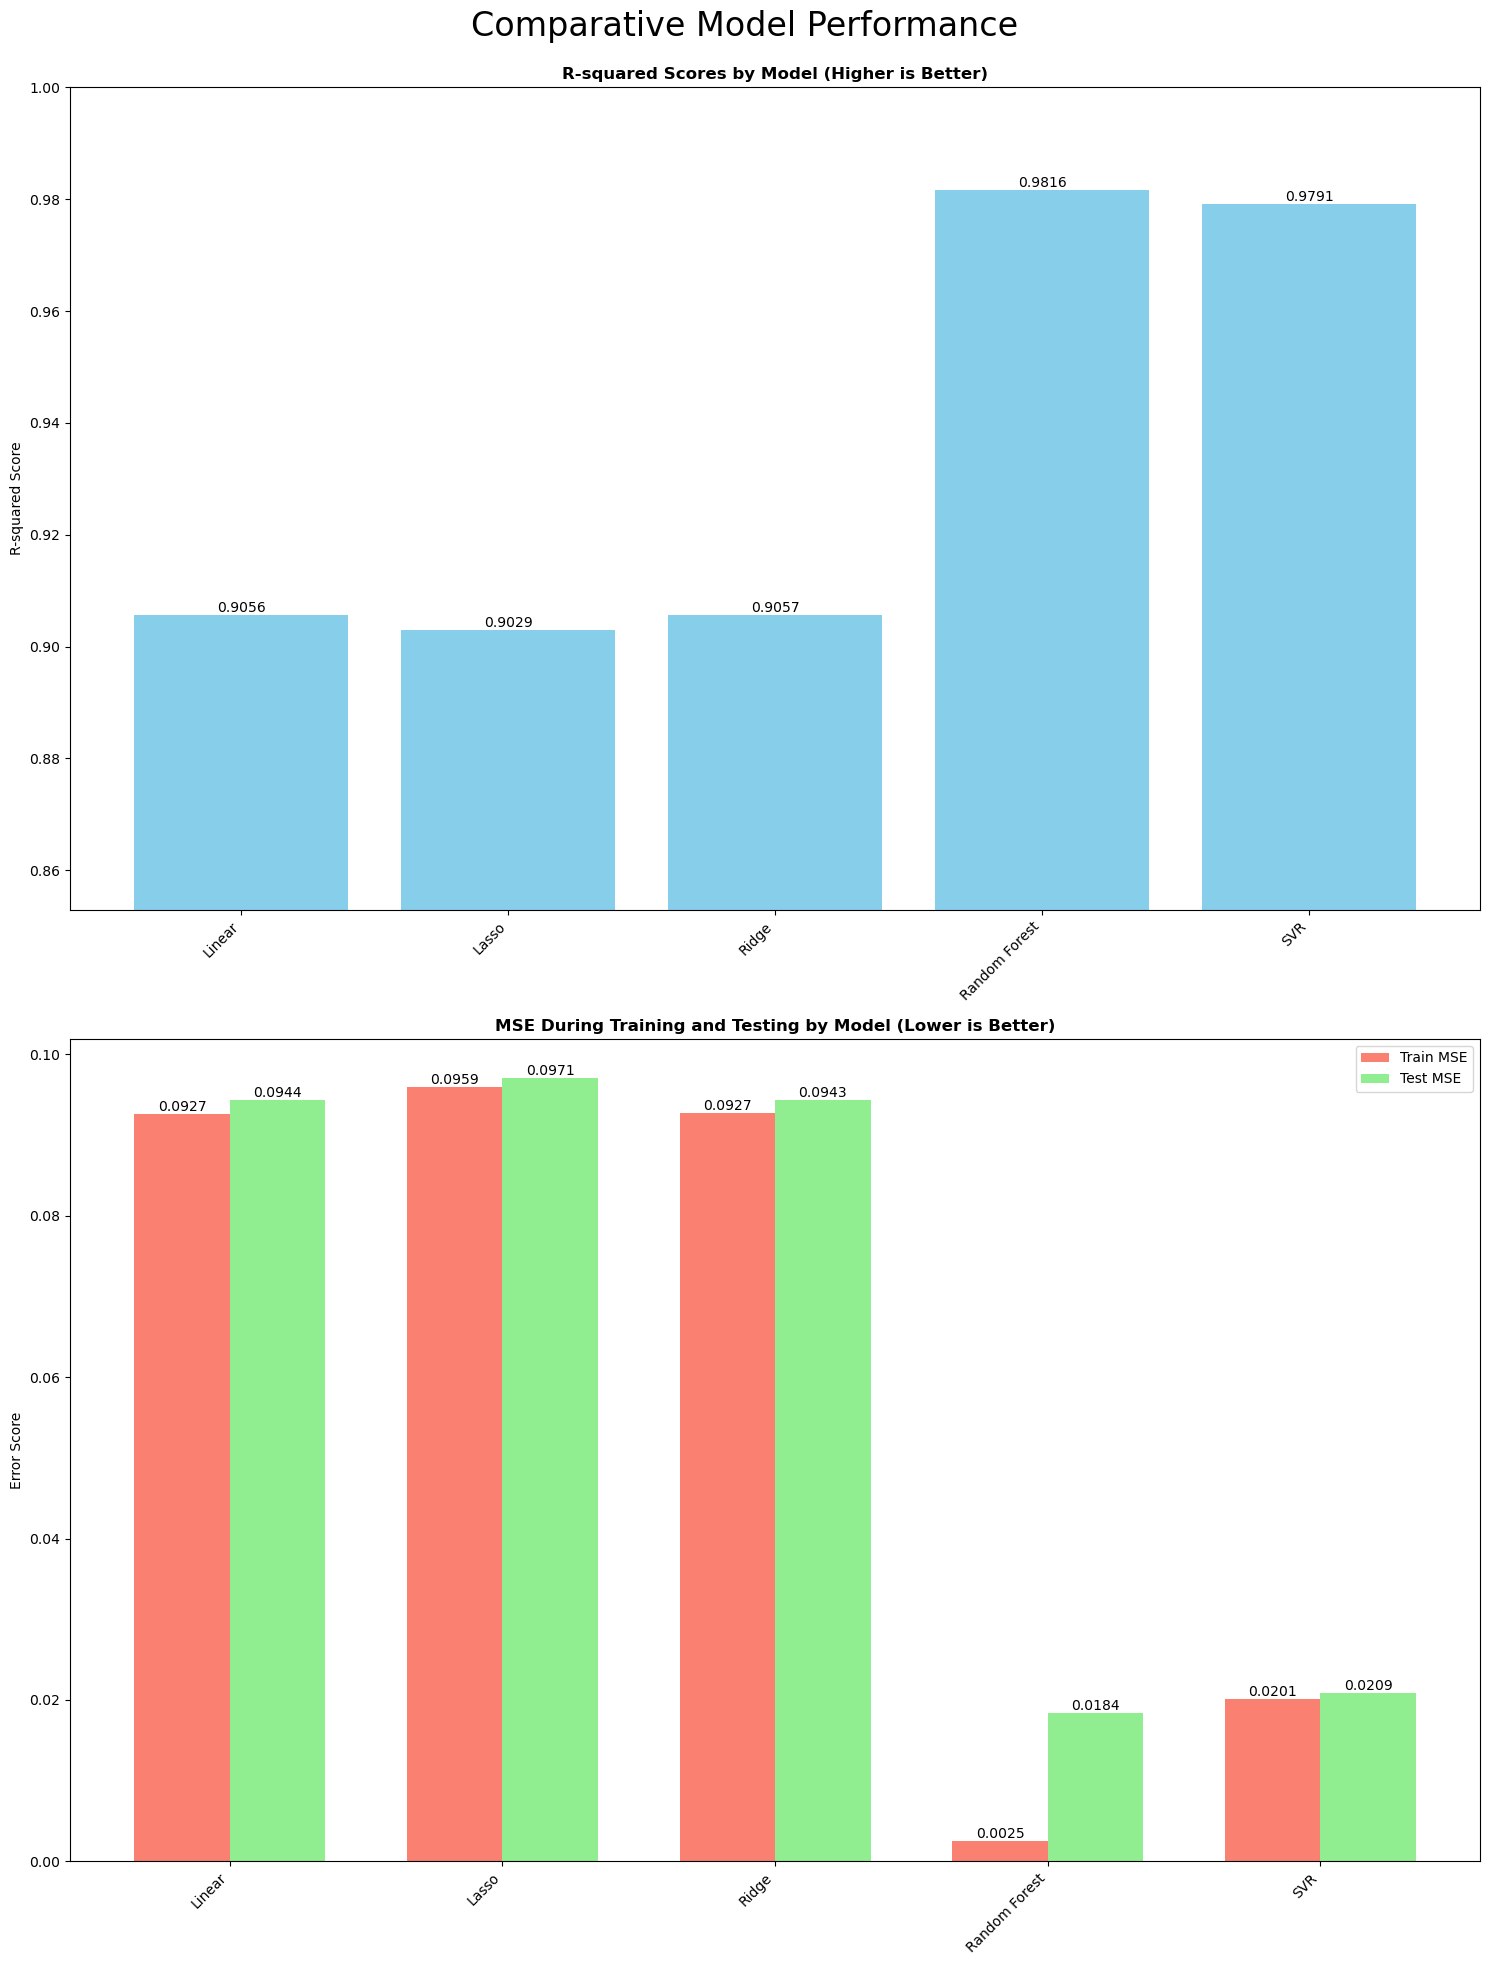

In [277]:
def plot_comparative_model_performance(model_results: dict[str, dict[str, object]]):
    """
    Creates a grouped bar chart to compare performance metrics across different models.

    Args:
    model_results (Dict[str, Dict[str, Any]]): Dictionary containing model names as keys and their results as values.
                                               Each model's results should include 'test_r2', 'train_mse', and 'test_mse'.

    Returns:
    None
    """
    # Extract model names and metrics
    models = list(model_results.keys())

    # Prepare data for plotting
    r2_scores = [model_results[model]['test_r2'] for model in models]
    train_mse_scores = [model_results[model]['train_mse'] for model in models]
    test_mse_scores = [model_results[model]['test_mse'] for model in models]

    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    fig.suptitle('Comparative Model Performance', fontsize=24)
    
    # Add separation between the main title and subplots
    plt.subplots_adjust(top=0.88)

    # Plot R-squared scores
    ax1.bar(models, r2_scores, color='skyblue')
    ax1.set_ylabel('R-squared Score')
    ax1.set_title('R-squared Scores by Model (Higher is Better)', fontweight='bold')
    ax1.set_xticks(np.arange(len(models)))  # Set fixed number of ticks
    ax1.set_xticklabels(models, rotation=45, ha='right')
    
    # Adjust the y-axis to start just below the minimum R-squared score
    r2_min = min(r2_scores) - 0.05
    r2_max = min(max(r2_scores) + 0.05, 1.00)
    ax1.set_ylim([r2_min, r2_max])

    # Add value labels on the R-squared bars
    for i, v in enumerate(r2_scores):
        ax1.text(i, v, f'{v:.4f}', ha='center', va='bottom')

    # Plot MSE and MAE scores
    x = np.arange(len(models))
    width = 0.35
    ax2.bar(x - width / 2, train_mse_scores, width, label='Train MSE', color='salmon')
    ax2.bar(x + width / 2, test_mse_scores, width, label='Test MSE', color='lightgreen')
    ax2.set_ylabel('Error Score')
    ax2.set_title('MSE During Training and Testing by Model (Lower is Better)', fontweight='bold')
    ax2.set_xticks(x)  # Set fixed number of ticks
    ax2.set_xticklabels(models, rotation=45, ha='right')
    ax2.legend()

    # Add value labels on the MSE and MAE bars
    for i, (mse, mae) in enumerate(zip(train_mse_scores, test_mse_scores)):
        ax2.text(i - width / 2, mse, f'{mse:.4f}', ha='center', va='bottom')
        ax2.text(i + width / 2, mae, f'{mae:.4f}', ha='center', va='bottom')

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.983])  # Add space at the top for the main title
    plt.show()


plot_comparative_model_performance(model_results)


In [261]:
def summarize_results(results: dict = model_results):
    """
    Displays the performance metrics of all models trained and evaluated in the train_and_evaluate_models function in a DataFrame 
    and returns the name of the best model based on R^2 score. The model with the highest R^2 score is considered the best model.

    Args:
        results (dict): Dictionary containing model names as keys and dictionaries containing the trained model object, 
                        predictions on the testing data, mean squared error, mean absolute error, R^2 score, and other model performance data as values
    Returns:
        best_performing_model (str): Name of the best model based on R^2 score
    """

    summary_df = pd.DataFrame({
        'Model': results.keys(),
        'Test R-squared': [result['test_r2'] for result in results.values()],
        "Train MSE": [result['train_mse'] for result in results.values()],
        'Test MSE': [result['test_mse'] for result in results.values()],
        'Test MAE': [result['test_mae'] for result in results.values()],
        'Test Adjusted R-squared': [result['test_adjusted_r2'] for result in results.values()]
    })

    display(md("## **Model Performance Summary**"))
    
    display_dataframe(summary_df)
    print()

    best_performing_model = summary_df.loc[summary_df['Test R-squared'].idxmax(), 'Model']
    display(md(f"## **Best Performing Model: {best_performing_model}** (based on R-squared score, the higher the better)"))
    display(md(f"* ### R-squared Score: {results[best_performing_model]['test_r2']}"))

    return best_performing_model

best_model = summarize_results()

## **Model Performance Summary**

Model 
 Test R-squared 
 Train MSE 
 Test MSE 
 Test MAE 
 Test Adjusted R-squared 
 
 
 
 
 0 
 Linear 
 0.905650 
 0.092664 
 0.094350 
 0.200895 
 0.905571 
 
 
 1 
 Lasso 
 0.902936 
 0.095928 
 0.097064 
 0.210487 
 0.902855 
 
 
 2 
 Ridge 
 0.905662 
 0.092674 
 0.094338 
 0.201331 
 0.905583 
 
 
 3 
 Random Forest 
 0.981568 
 0.002505 
 0.018432 
 0.067688 
 0.981553 
 
 
 4 
 SVR 
 0.979110 
 0.020121 
 0.020890 
 0.082354 
 0.979092

## **Best Performing Model: Random Forest** (based on R-squared score, the higher the better)

* ### R-squared Score: 0.9815684621946372

## **Model Performance Comparison Visualisations**

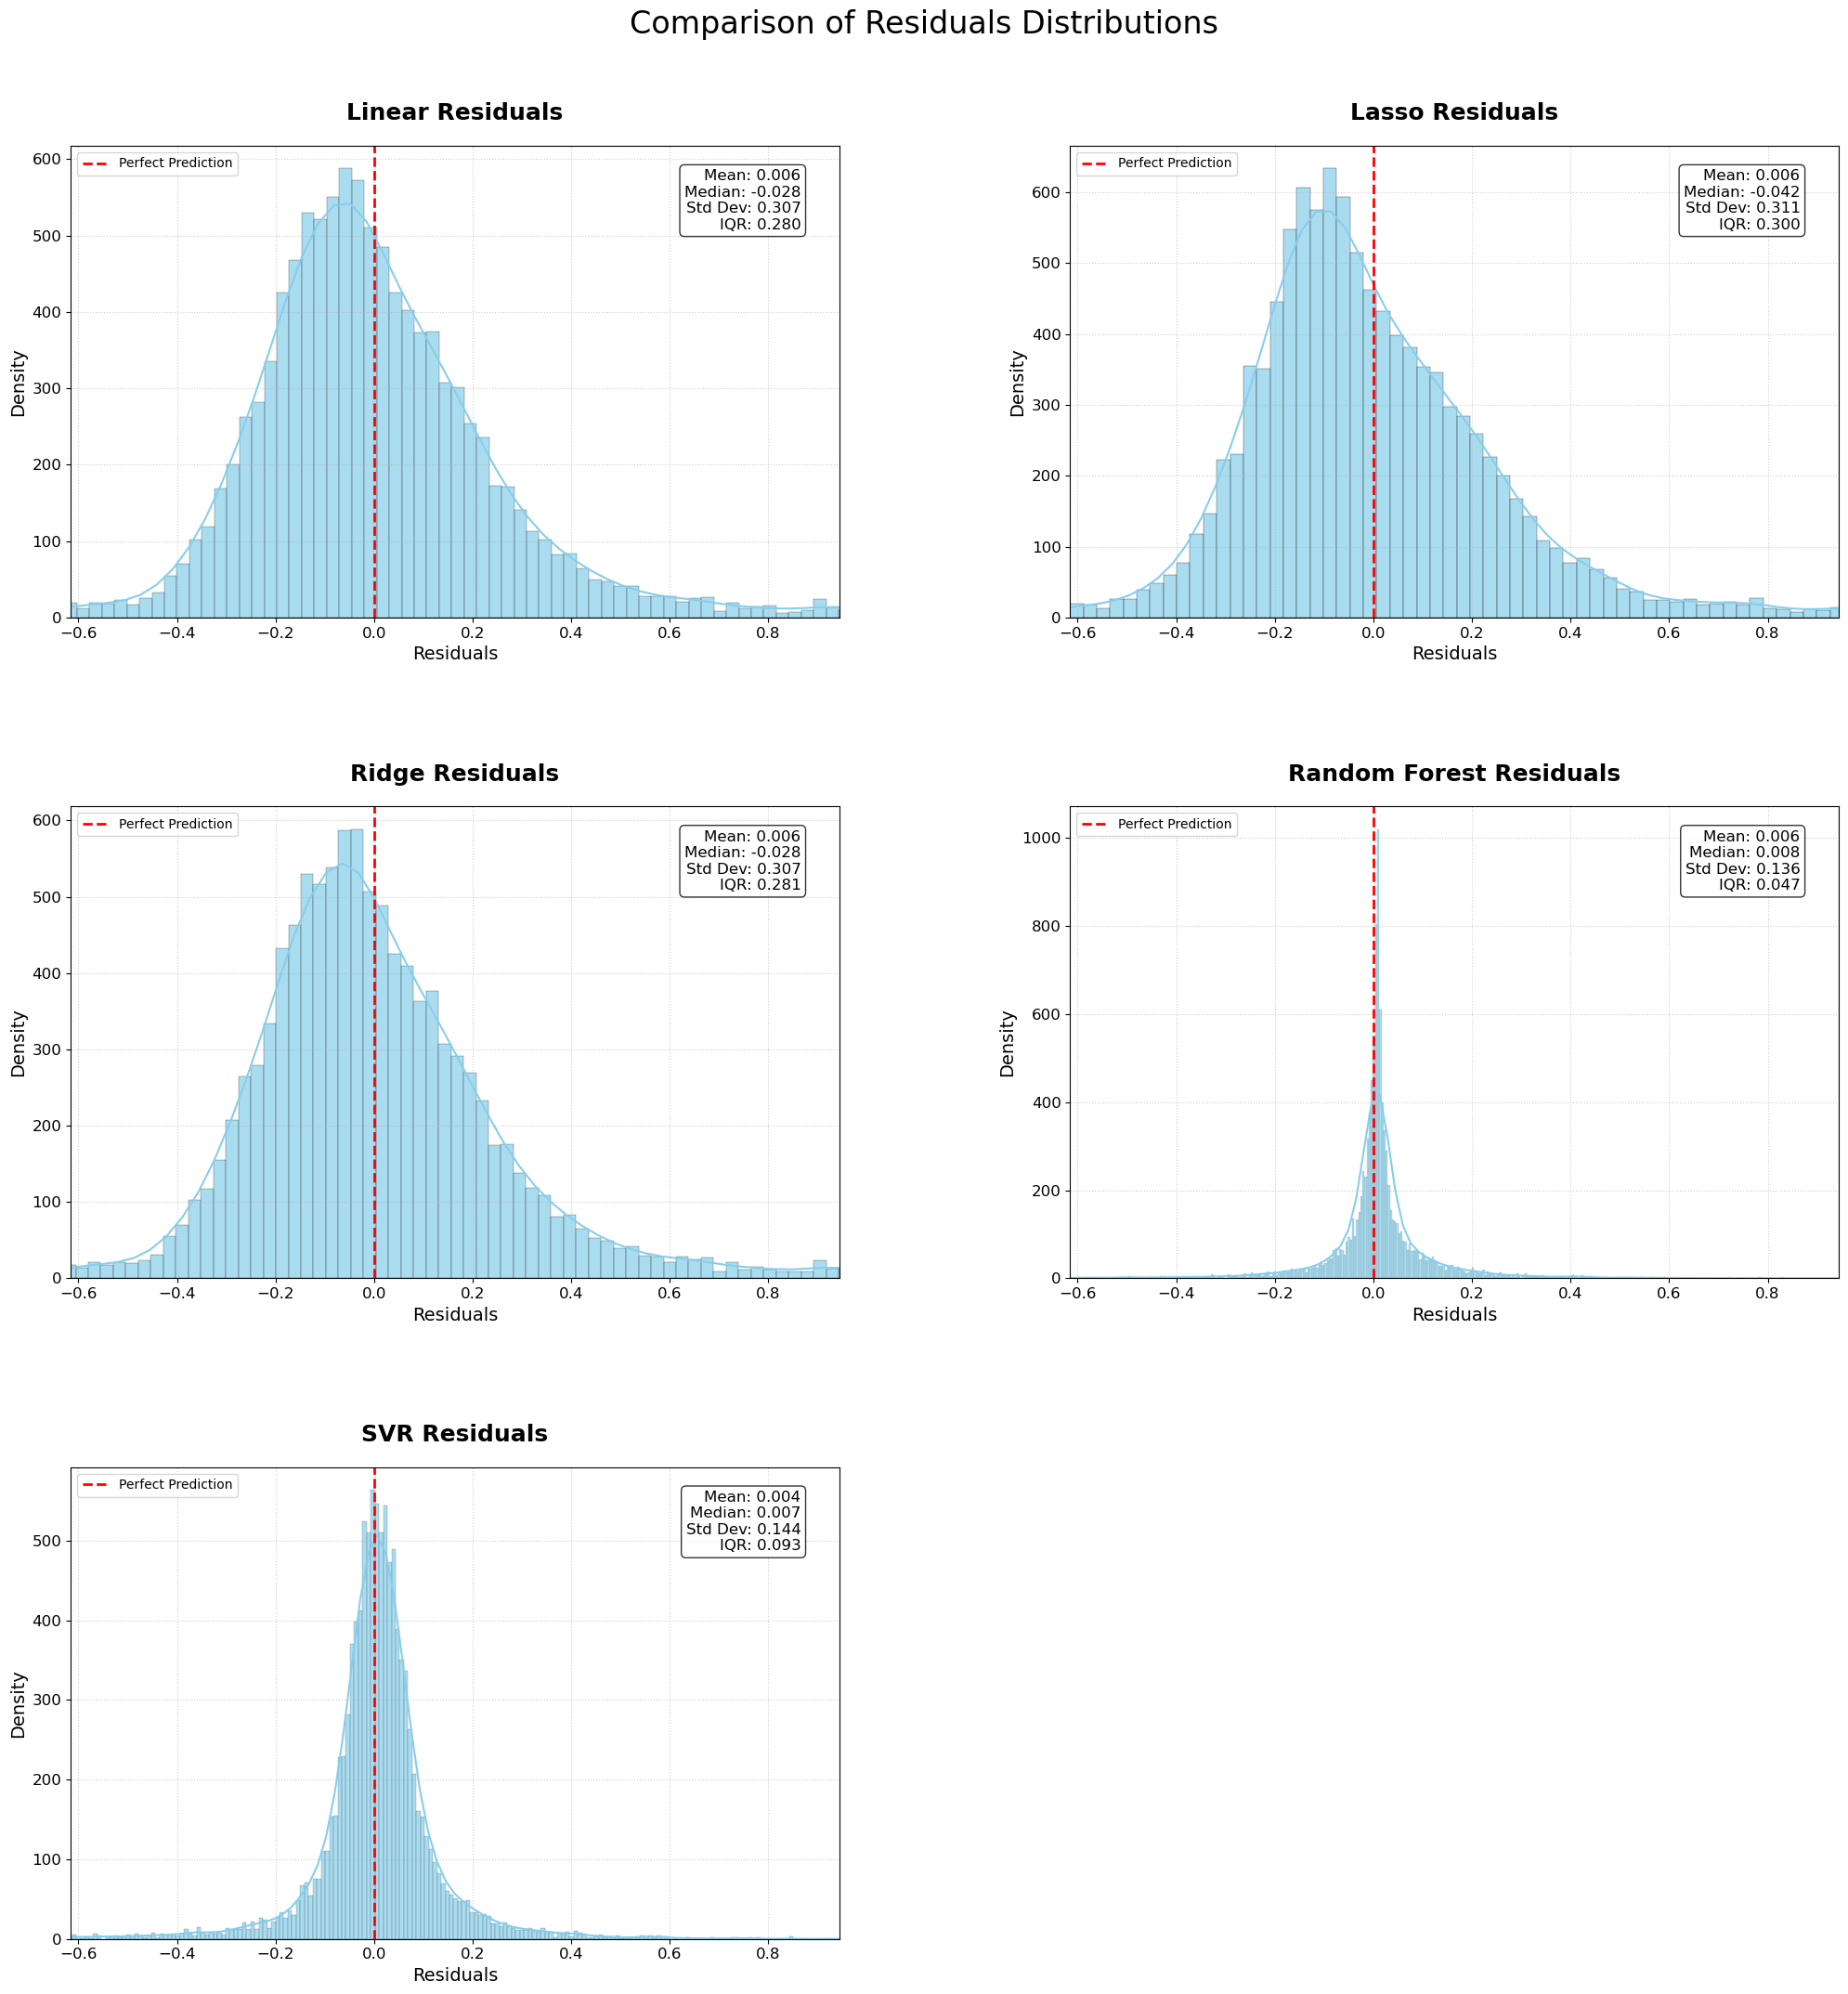

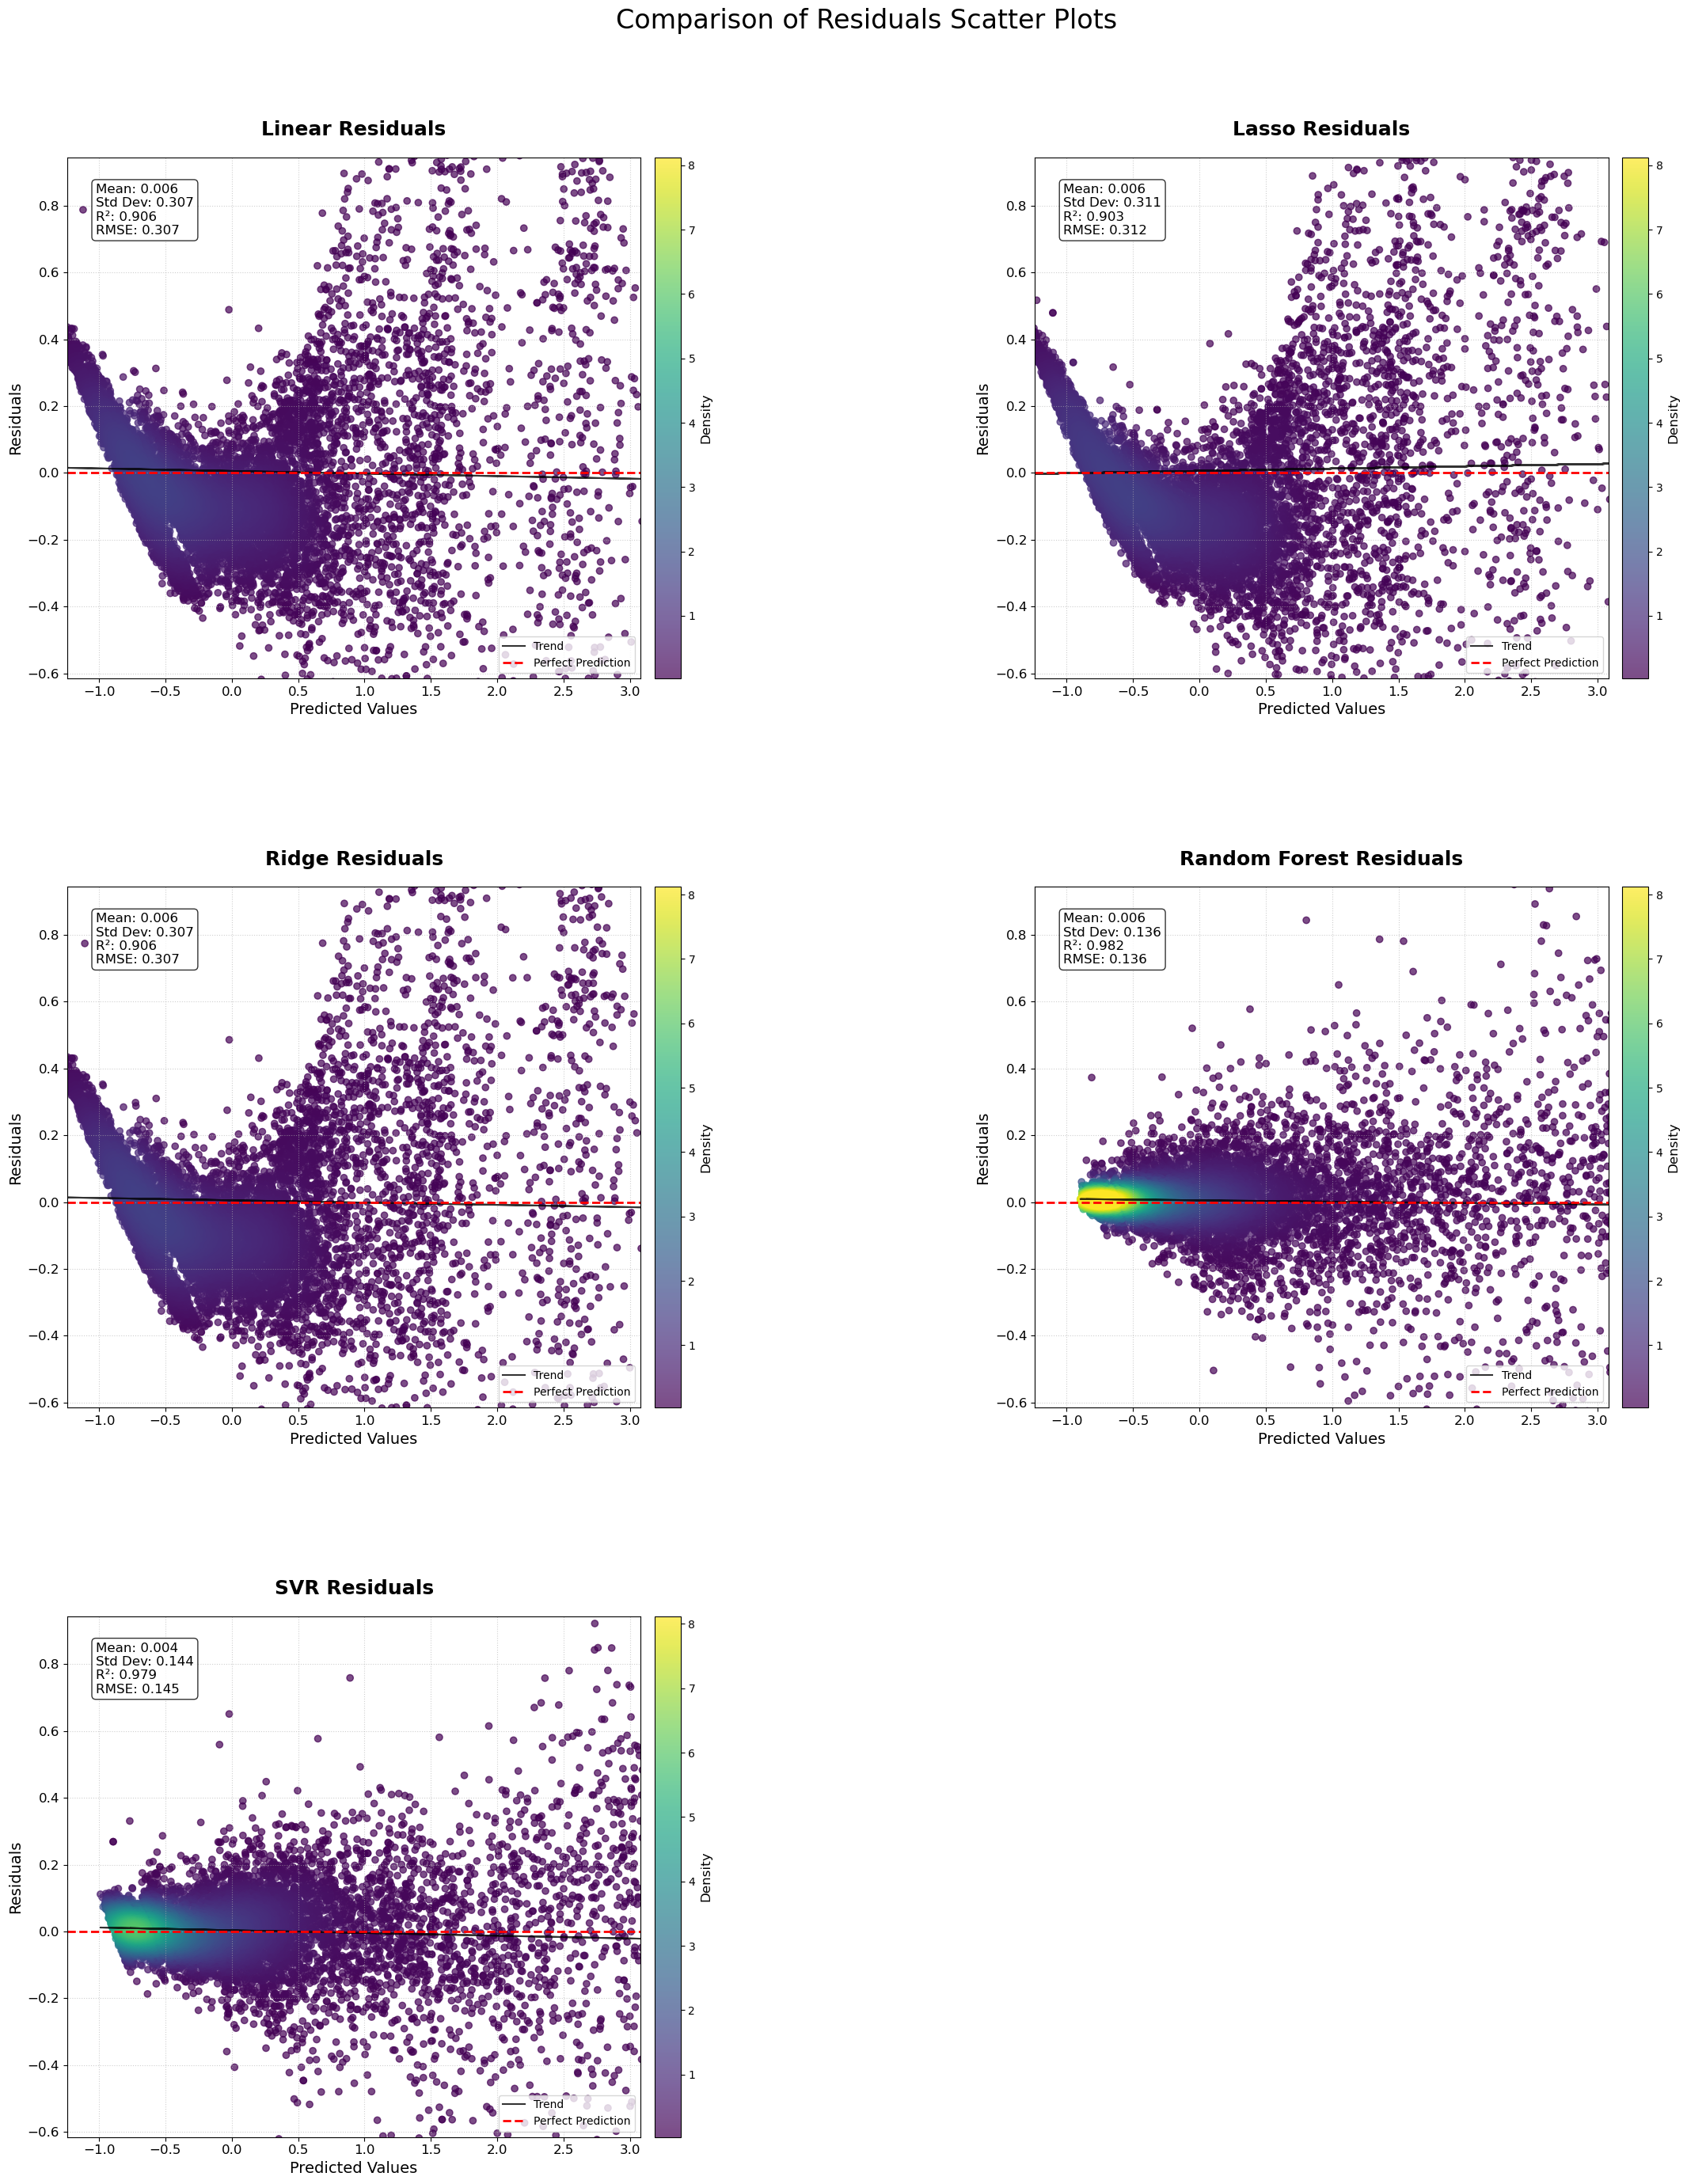

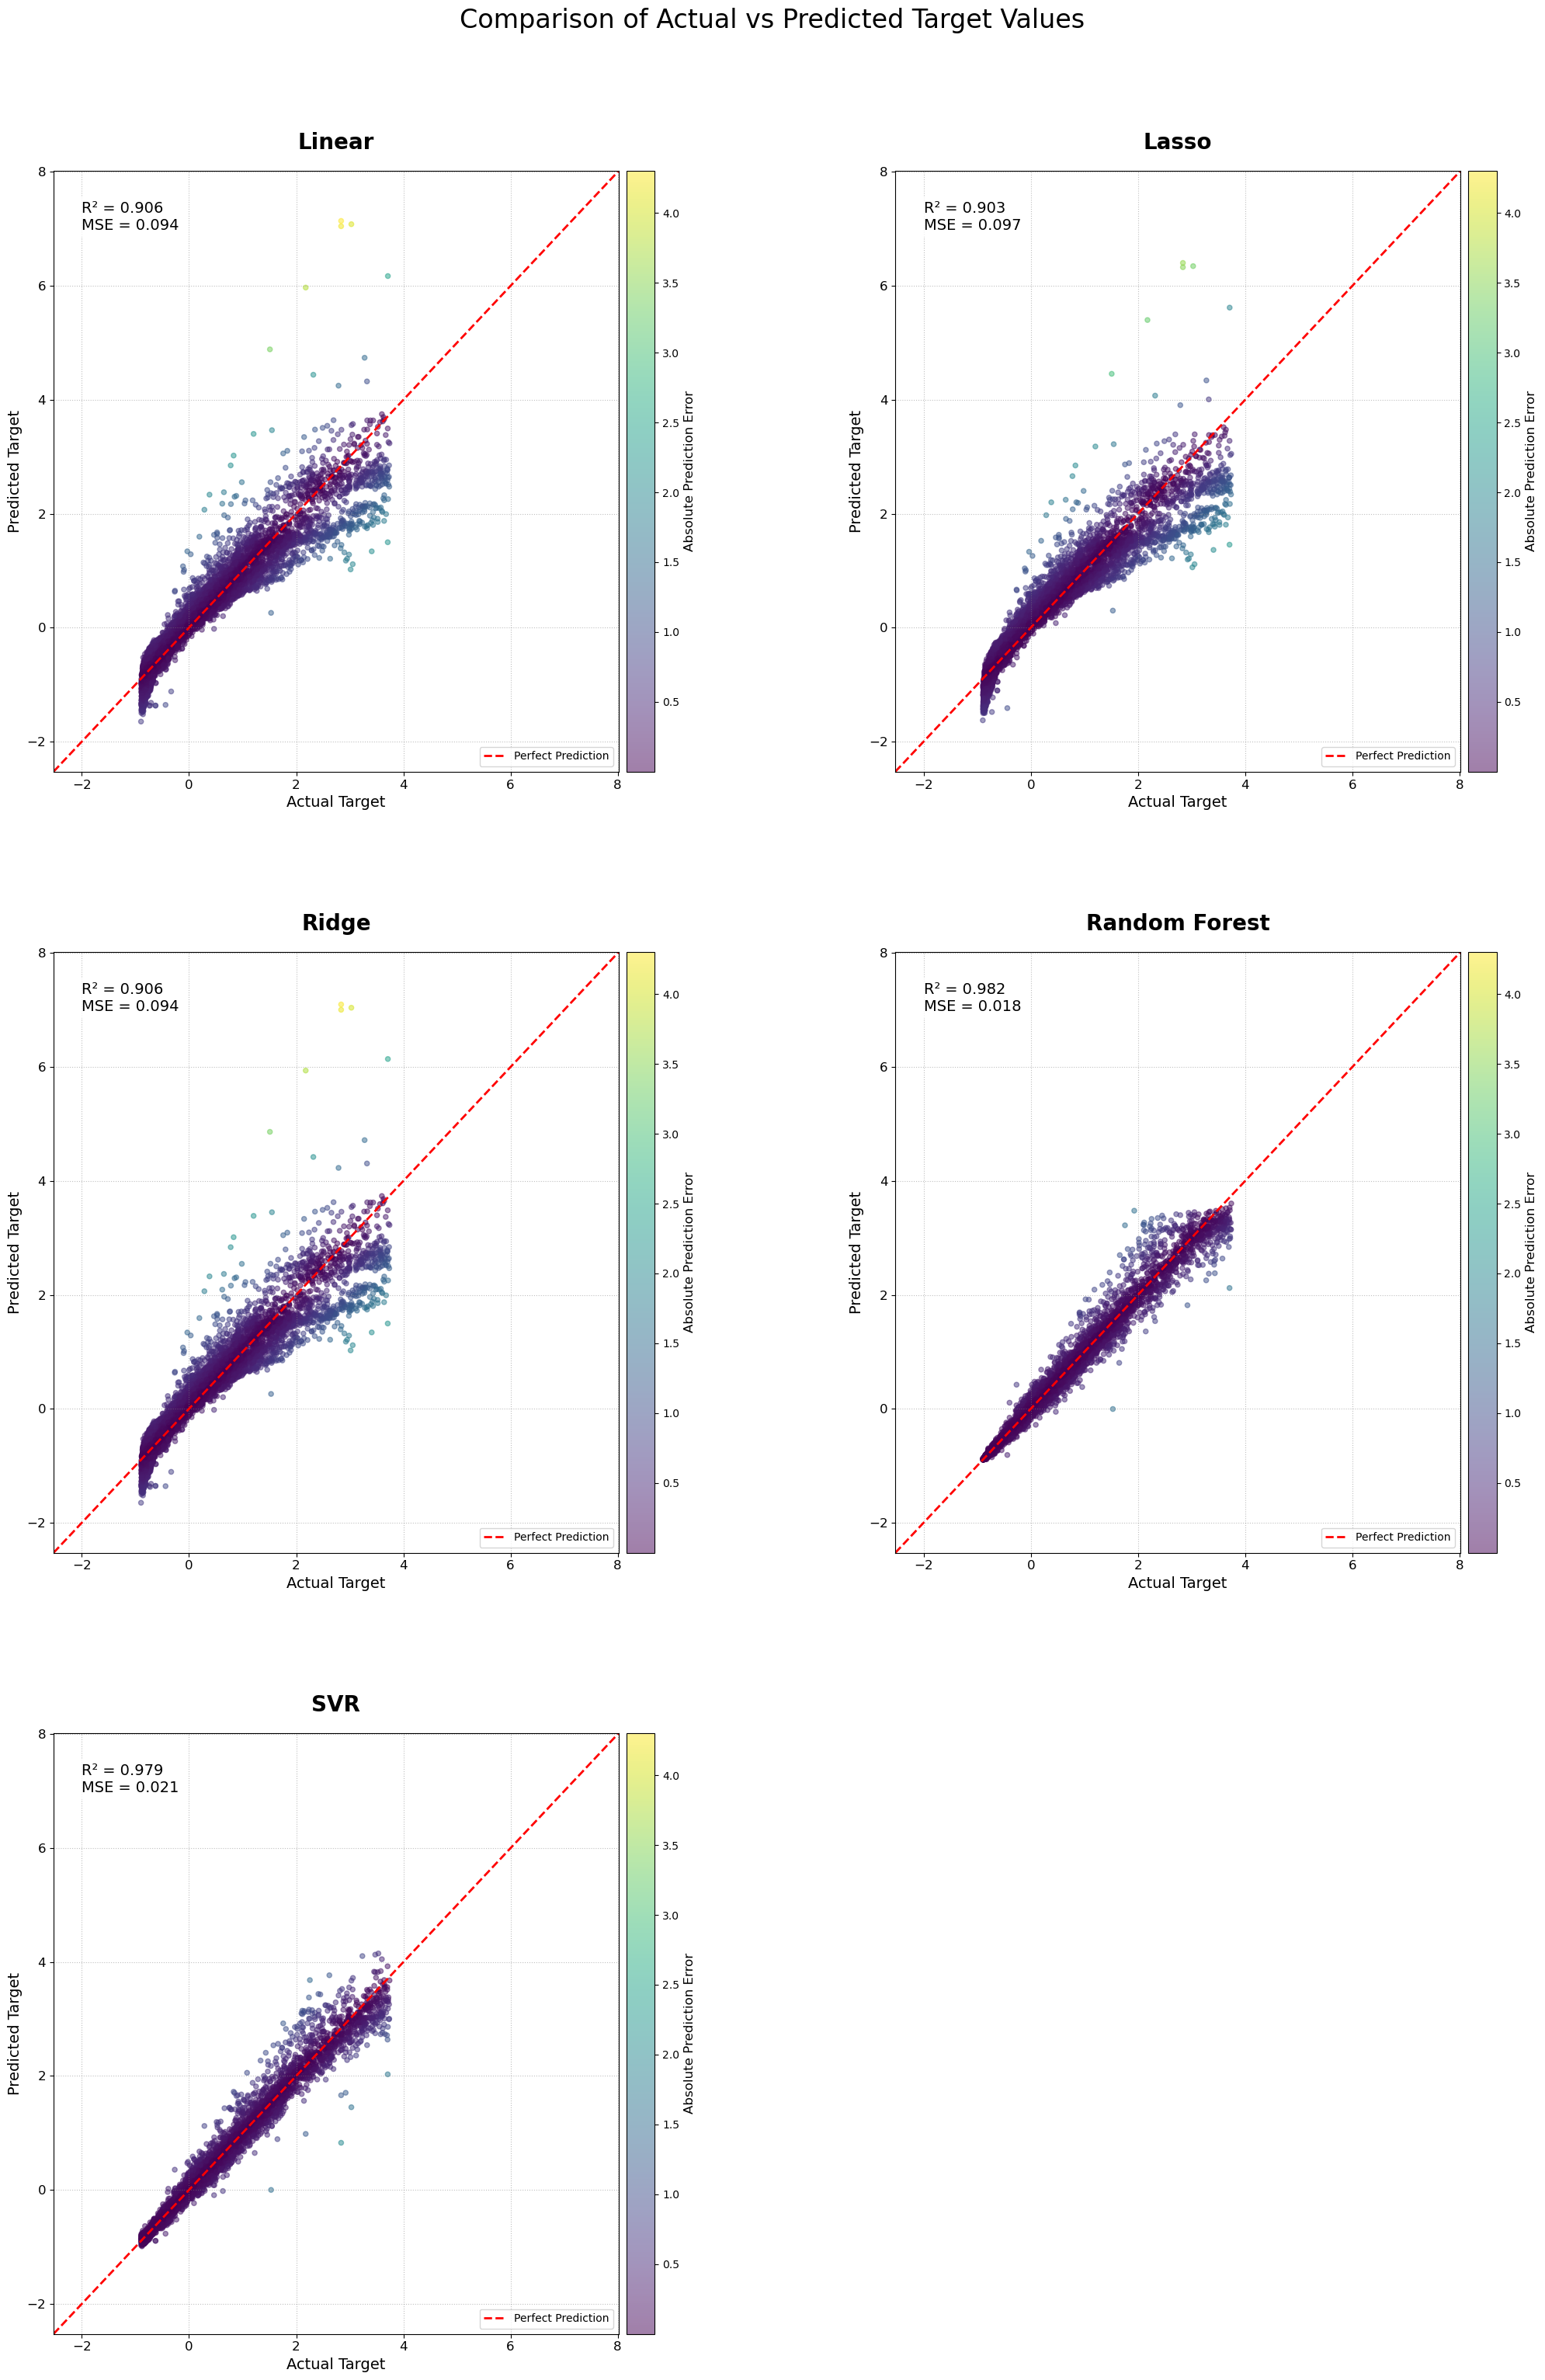

In [262]:
def plot_residuals_histograms_comparison(model_results: dict[str, dict], y_test: np.ndarray) -> None:
    """
    Plot histograms of residuals for multiple models vertically.
    
    Args:
        model_results (dict[str, dict]): Dictionary of model results, where each key is a model name
        and each value is a dictionary containing model predictions
        y_test (np.ndarray): Actual target values
    Returns:
        None
    """
    num_models = len(model_results)
    num_rows = math.ceil(num_models / 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 7*num_rows))
    
    fig.suptitle('Comparison of Residuals Distributions', fontsize=24, y=1.02)
    
    axes_flat = axes.flatten() if num_models > 1 else [axes]
    
    # Determine global x-axis limits
    all_residuals = []
    for results in model_results.values():
        all_residuals.extend(y_test - results['y_test_predictions'])
    global_xlim = np.percentile(all_residuals, [1, 99])
    
    for ax, (model_name, results) in zip(axes_flat, model_results.items()):
        y_pred = results['y_test_predictions']
        residuals = y_test - y_pred
        
        # Plot histogram and KDE
        sns.histplot(residuals, kde=True, ax=ax, color='skyblue', edgecolor='black', alpha=0.7)
        
        ax.set_title(f'{model_name} Residuals', fontsize=18, fontweight='bold', pad=20)
        ax.set_xlabel('Residuals', fontsize=14)
        ax.set_ylabel('Density', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Perfect Prediction')
        ax.set_xlim(global_xlim)
        
        # Calculate and display statistics
        mean_residual = np.mean(residuals)
        median_residual = np.median(residuals)
        std_residual = np.std(residuals)
        q1, q3 = np.percentile(residuals, [25, 75])
        iqr = q3 - q1
        
        stats_text = (f'Mean: {mean_residual:.3f}\n'
                      f'Median: {median_residual:.3f}\n'
                      f'Std Dev: {std_residual:.3f}\n'
                      f'IQR: {iqr:.3f}')
        
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=12)
        
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.legend(loc='upper left')
    
    for ax in axes_flat[num_models:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.4, wspace=0.3)
    plt.show()


def plot_residuals_scatter_comparison(model_results: dict[str, dict], y_test: np.ndarray) -> None:
    """
    Plots scatter plot of residuals vs predicted values for multiple models vertically.
    
    Args:
        model_results (dict[str, dict]): Dictionary of model results, where each key is a model name
        and each value is a dictionary containing model predictions
        y_test (np.ndarray): Actual target values
    Returns:
        None
    """
    num_models = len(model_results)
    num_rows = math.ceil(num_models / 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(22, 9*num_rows))  # Increased width for colorbars
    
    fig.suptitle('Comparison of Residuals Scatter Plots', fontsize=24, y=1.02)
    
    axes_flat = axes.flatten() if num_models > 1 else [axes]
    
    # Determine global axis limits and density range
    all_predicted = []
    all_residuals = []
    all_densities = []
    for results in model_results.values():
        y_pred = results['y_test_predictions']
        residuals = y_test - y_pred
        all_predicted.extend(y_pred)
        all_residuals.extend(residuals)
        xy = np.vstack([y_pred, residuals])
        all_densities.extend(stats.gaussian_kde(xy)(xy))
    
    global_xlim = np.percentile(all_predicted, [1, 99])
    global_ylim = np.percentile(all_residuals, [1, 99])
    vmin, vmax = np.percentile(all_densities, [5, 95])  # For consistent colorbar scale
    
    for ax, (model_name, results) in zip(axes_flat, model_results.items()):
        y_pred = results['y_test_predictions']
        residuals = y_test - y_pred
        
        # Create scatter plot with density coloring
        xy = np.vstack([y_pred, residuals])
        density = stats.gaussian_kde(xy)(xy)
        
        idx = density.argsort()
        x, y, z = y_pred[idx], residuals[idx], density[idx]
        
        scatter = ax.scatter(x, y, c=z, cmap='viridis', alpha=0.7, vmin=vmin, vmax=vmax)
        
        # Add trend line
        z = np.polyfit(y_pred, residuals, 1)
        p = np.poly1d(z)
        ax.plot(y_pred, p(y_pred), "black", alpha=0.8, label='Trend')  # Changed color to black
        
        ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')  # Changed color to red
        ax.set_xlim(global_xlim)
        ax.set_ylim(global_ylim)
        
        ax.set_title(f'{model_name} Residuals', fontsize=18, fontweight='bold', pad=20)
        ax.set_xlabel('Predicted Values', fontsize=14)
        ax.set_ylabel('Residuals', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Calculate and display statistics
        mean_residual = np.mean(residuals)
        std_residual = np.std(residuals)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        stats_text = (f'Mean: {mean_residual:.3f}\n'
                      f'Std Dev: {std_residual:.3f}\n'
                      f'R²: {r2:.3f}\n'
                      f'RMSE: {rmse:.3f}')
        
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=12)
        
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.legend(loc='lower right')
        
        # Add individual colorbar
        cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
        cbar.set_label('Density', fontsize=12)
        cbar.ax.tick_params(labelsize=10)
    
    for ax in axes_flat[num_models:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.4, wspace=0.4)  # Increased wspace for colorbars
    
    plt.show()


def plot_actual_vs_predicted_comparison(model_results: dict[str, dict], y_test: np.ndarray, target_name: str = "Target") -> None:
    """
    Plots enhanced actual vs predicted values comparison for multiple regression models with improved range.
    
    Args:
    model_results (dict[str, dict]): Dictionary of model results, where each key is a model name
                                     and each value is a dictionary containing model predictions.
    y_test (np.ndarray): Actual target values.
    target_name (str): Name of the target variable for axis labels.
    
    Returns:
    None
    """
    num_models = len(model_results)
    num_rows = math.ceil(num_models / 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 10*num_rows))
    fig.suptitle(f'Comparison of Actual vs Predicted {target_name} Values', fontsize=24, y=1.02)
    
    # Flatten axes array for easy iteration
    axes_flat = axes.flatten() if num_models > 2 else ([axes] if num_models == 1 else axes)
    
    # Calculate global min and max for consistent scaling
    all_y = np.concatenate([y_test] + [results['y_test_predictions'] for results in model_results.values()])
    global_min, global_max = np.min(all_y), np.max(all_y)
    
    # Calculate the range and add a buffer (e.g., 10% of the range on each side)
    data_range = global_max - global_min
    buffer = 0.1 * data_range
    plot_min = global_min - buffer
    plot_max = global_max + buffer
    
    # Ensure the aspect ratio is equal and adjust the limits if necessary
    center = (plot_min + plot_max) / 2
    half_range = max(plot_max - center, center - plot_min)
    plot_min = center - half_range
    plot_max = center + half_range
    
    # Calculate global min and max errors
    all_errors = np.concatenate([np.abs(y_test - results['y_test_predictions']) for results in model_results.values()])
    vmin, vmax = np.min(all_errors), np.max(all_errors)
    
    for ax, (model_name, results) in zip(axes_flat, model_results.items()):
        y_pred = results['y_test_predictions']
        errors = np.abs(y_test - y_pred)
        
        # Set background color to white and add grid
        ax.set_facecolor('white')
        ax.grid(True, linestyle=':', alpha=0.5, color='gray')
        
        # Create scatter plot with smaller, more transparent points
        scatter = ax.scatter(y_test, y_pred, c=errors, cmap='viridis', alpha=0.5, s=20, vmin=vmin, vmax=vmax)
        
        # Add diagonal line for perfect predictions
        ax.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', linewidth=2, label='Perfect Prediction')
        
        # Set consistent scale with balanced range
        ax.set_xlim(plot_min, plot_max)
        ax.set_ylim(plot_min, plot_max)
        
        # Adjust title and labels
        ax.set_title(model_name, fontsize=20, fontweight='bold', pad=20)
        ax.set_ylabel(f'Predicted {target_name}', fontsize=14)
        ax.set_xlabel(f'Actual {target_name}', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Add legend for perfect prediction line
        ax.legend(fontsize=10, loc='lower right')
        
        # Calculate and display metrics
        r2 = results['test_r2']
        mse = results['test_mse']
        ax.text(0.05, 0.95, f'R² = {r2:.3f}\nMSE = {mse:.3f}', 
                transform=ax.transAxes, verticalalignment='top', fontsize=14,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
        # Add colorbar for each subplot
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label('Absolute Prediction Error', fontsize=12)
    
    # Hide any unused subplots
    for ax in axes_flat[num_models:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.4)
    plt.show()

    
plot_residuals_histograms_comparison(model_results, y_test)
plot_residuals_scatter_comparison(model_results, y_test)
plot_actual_vs_predicted_comparison(model_results, y_test)

### **Functions for Displaying Individual Model Perfomance Visuals**

In [272]:
FEATURE_LIST = list(X_train.columns)

def create_fit_function_equation_markdown(intercept: int, coefficient_list: list, feature_list: list = FEATURE_LIST, num_decimal_places: int = NUM_DECIMAL_PLACES) -> str:
    model_equation = f"### {TARGET_COLUMN_NAME} = {intercept:.{num_decimal_places}f}"
    
    for i in range(len(coefficient_list)):
        model_equation += f" + {coefficient_list[i]:.{num_decimal_places}f}({feature_list[i]})"
        
    return model_equation

def display_model_evaluation_results(model_name: str, results: dict = model_results) -> None:
    """
    Displays the evaluation results for a given model.
    
    Args:
        model_name (str): Name of the model
        results (dict): Dictionary containing the evalutation results of each model
    Returns: None
    """
    display_markdown(md(f"### **Model: {model_name}**"))
    display_markdown(md(f"* #### **Train MSE:** {results[model_name]["train_mse"]:.{NUM_DECIMAL_PLACES}f}"))
    display_markdown(md(f"* #### **Test MSE:** {results[model_name]["test_mse"]:.{NUM_DECIMAL_PLACES}f}"))
    display_markdown(md(f"* #### **Test MAE:** {results[model_name]["test_mae"]:.{NUM_DECIMAL_PLACES}f}"))
    display_markdown(md(f"* #### **Test R^2:** {results[model_name]["test_r2"]:.{NUM_DECIMAL_PLACES}f}"))
    display_markdown(md(f"* #### **Test Adjusted R^2:** {results[model_name]["test_adjusted_r2"]:.{NUM_DECIMAL_PLACES}f}"))
    
    if model_name in ['Linear', 'Lasso', 'Ridge']:
        display_markdown(md(f"### **Model Equation:**"))
        display_markdown(md(create_fit_function_equation_markdown(results[model_name]["intercept"], results[model_name]["coefficients"])))
        
    
def plot_residuals_histogram(model_name: str, residuals: np.ndarray) -> None:
    """
    Display a histogram of residuals with KDE and statistics.
    
    Args:
        residuals (np.ndarray): Residuals (actual - predicted)
        model_name (str): Name of the model
    Returns:
        None
    """
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Density')
    plt.title(f'Histogram of Residuals ({model_name})')
    plt.grid(True)
    
    mean_residual = np.mean(residuals)
    median_residual = np.median(residuals)
    std_residual = np.std(residuals)
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1

    stats_text = (f'Mean: {mean_residual:.3f}\n'
                  f'Median: {median_residual:.3f}\n'
                  f'Std Dev: {std_residual:.3f}\n'
                  f'IQR: {iqr:.3f}')
    
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=12)
    
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
    plt.legend()
    plt.show()

def plot_residuals_scatter(model_name: str, y_pred: np.ndarray, residuals: np.ndarray) -> None:
    """
    Displays a scatter plot of residuals vs predicted values with density coloring.
    
    Args:
        y_pred (np.ndarray): Predicted target values
        residuals (np.ndarray): Residuals (actual - predicted)
        model_name (str): Name of the model
    Returns:
        None
    """
    plt.figure(figsize=(12, 6))
    
    # Calculate density for coloring
    xy = np.vstack([y_pred, residuals])
    density = stats.gaussian_kde(xy)(xy)
    
    idx = density.argsort()
    x, y, z = y_pred[idx], residuals[idx], density[idx]
    
    scatter = plt.scatter(x, y, c=z, cmap='viridis', alpha=0.7)
    
    # Add trend line
    z = np.polyfit(y_pred, residuals, 1)
    p = np.poly1d(z)
    plt.plot(y_pred, p(y_pred), "black", alpha=0.8, label='Trend')

    plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('Predicted Target Values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(f'Residual Plot ({model_name})')
    plt.grid(True)
    plt.legend()
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    
    plt.show()

def plot_actual_vs_predicted(model_name: str, y_test: np.ndarray, y_pred: np.ndarray, target_name: str = "Target") -> None:
    """
    Displays a plot of actual vs predicted values with error gradient.
    
    Args:
        y_test (np.ndarray): Actual target values
        y_pred (np.ndarray): Predicted target values
        model_name (str): Name of the model
        target_name (str): Name of the target variable for axis labels
    Returns:
        None
    """
    errors = np.abs(y_test - y_pred)
    plt.figure(figsize=(13, 6))
    scatter = plt.scatter(y_test, y_pred, c=errors, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Absolute Error')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.title(f'Actual vs. Predicted with Error Gradient ({model_name})')
    plt.grid(True)

    # Calculate and display metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.3f}\nMSE = {mse:.3f}', 
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Move legend to the bottom right
    plt.legend(loc='lower right')
    
    plt.show()

## **Individual Model Evaluation and Performance Visualizations**

### **Linear Model**

### **Model: Linear**

* #### **Train MSE:** 0.0926643

* #### **Test MSE:** 0.0943501

* #### **Test MAE:** 0.2008947

* #### **Test R^2:** 0.9056499

* #### **Test Adjusted R^2:** 0.9055711

### **Model Equation:**

### price = -0.7514135 + -0.0027873(carat) + 1.2786168(cut) + 0.0065850(color) + -0.0151295(clarity) + -0.2451774(depth) + -0.0290248(table) + 0.0310432(x) + 0.0811718(y) + 0.1259466(z)

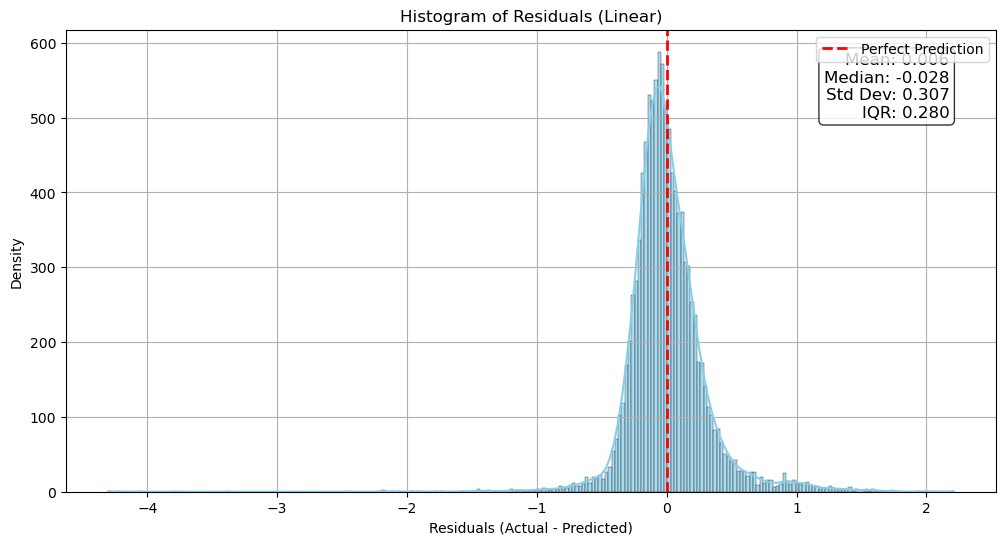

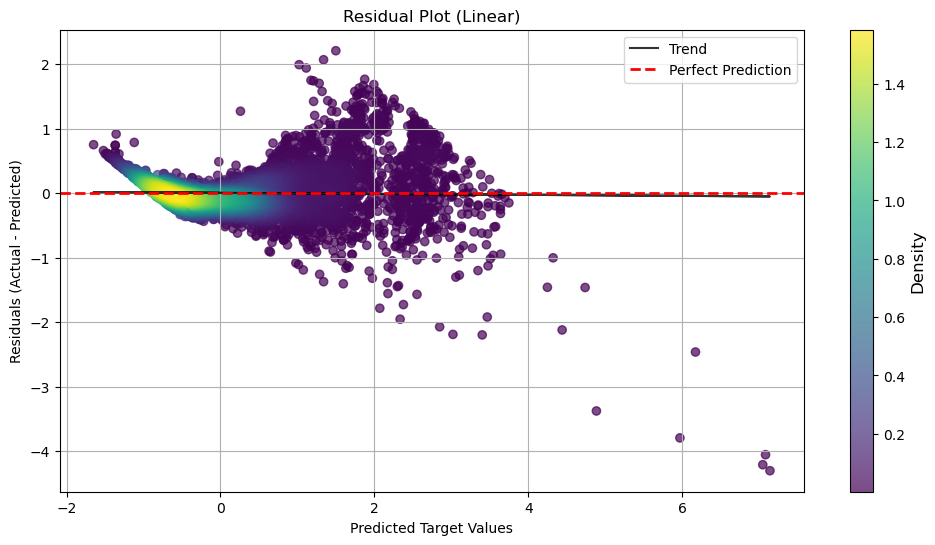

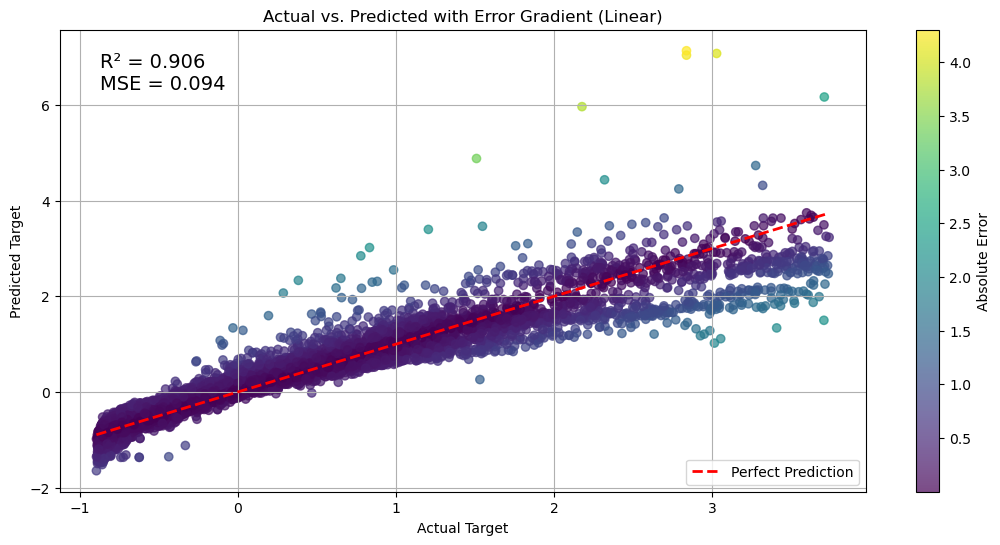

In [273]:
linear_model_name: str = "Linear"

linear_y_train_predictions = model_results[linear_model_name]["y_train_predictions"]
linear_y_test_predictions = model_results[linear_model_name]["y_test_predictions"]
linear_residuals = y_test - linear_y_test_predictions


display_model_evaluation_results(linear_model_name)
plot_residuals_histogram(linear_model_name, linear_residuals)
plot_residuals_scatter(linear_model_name, linear_y_test_predictions, linear_residuals)
plot_actual_vs_predicted(linear_model_name, y_test, linear_y_test_predictions)


### **Lasso Model**

### **Model: Lasso**

* #### **Train MSE:** 0.0959281

* #### **Test MSE:** 0.0970641

* #### **Test MAE:** 0.2104870

* #### **Test R^2:** 0.9029359

* #### **Test Adjusted R^2:** 0.9028548

### **Model Equation:**

### price = -0.7226391 + -0.0000000(carat) + 1.0252534(cut) + 0.0000000(color) + -0.0000000(clarity) + -0.0000000(depth) + -0.0019469(table) + 0.0311706(x) + 0.0736968(y) + 0.1247469(z)

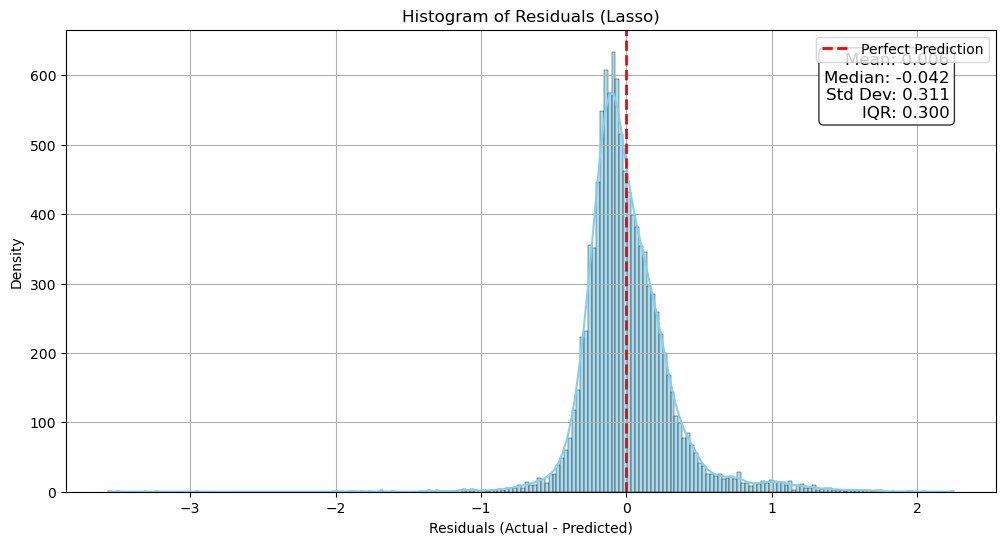

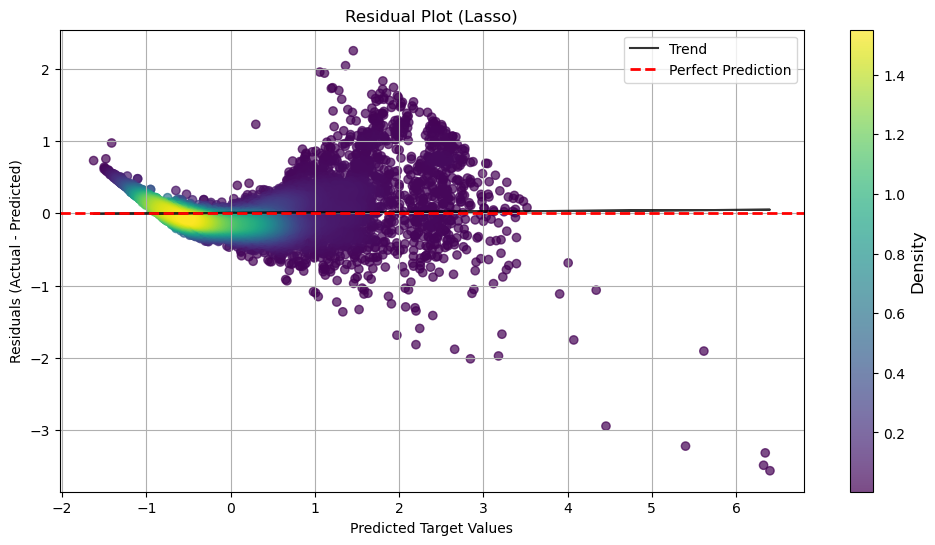

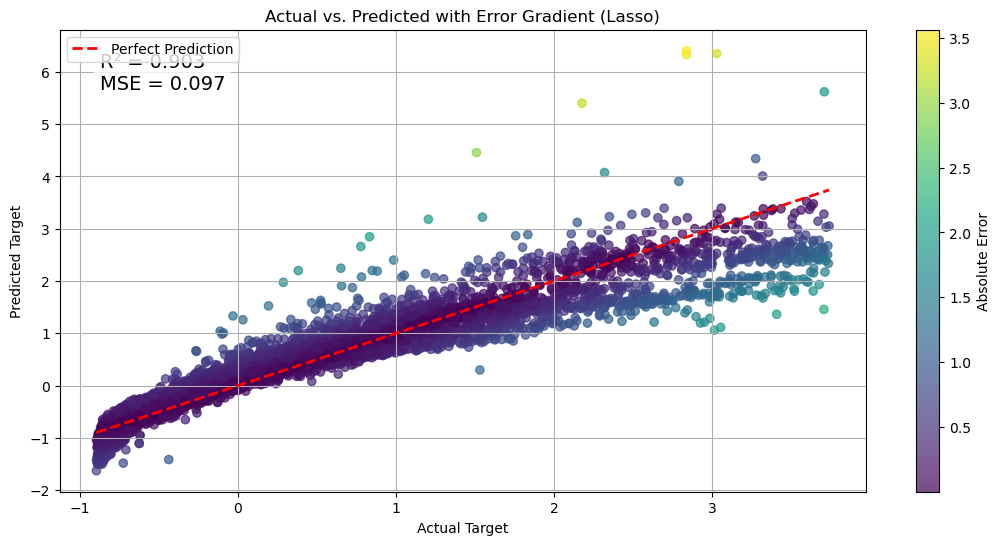

In [268]:
lasso_model_name: str = "Lasso"

lasso_y_train_predictions = model_results[lasso_model_name]["y_train_predictions"]
lasso_y_test_predictions = model_results[lasso_model_name]["y_test_predictions"]
lasso_residuals = y_test - lasso_y_test_predictions


display_model_evaluation_results(lasso_model_name)
plot_residuals_histogram(lasso_model_name, lasso_residuals)
plot_residuals_scatter(lasso_model_name, lasso_y_test_predictions, lasso_residuals)
plot_actual_vs_predicted(lasso_model_name, y_test, lasso_y_test_predictions)

### **Ridge Model**

### **Model: Ridge**

* #### **Train MSE:** 0.0926741

* #### **Test MSE:** 0.0943385

* #### **Test MAE:** 0.2013307

* #### **Test R^2:** 0.9056615

* #### **Test Adjusted R^2:** 0.9055828

### **Model Equation:**

### price = -0.7510668 + -0.0044113(carat) + 1.2642307(cut) + 0.0055560(color) + -0.0150292(clarity) + -0.2285056(depth) + -0.0280146(table) + 0.0310434(x) + 0.0809639(y) + 0.1260650(z)

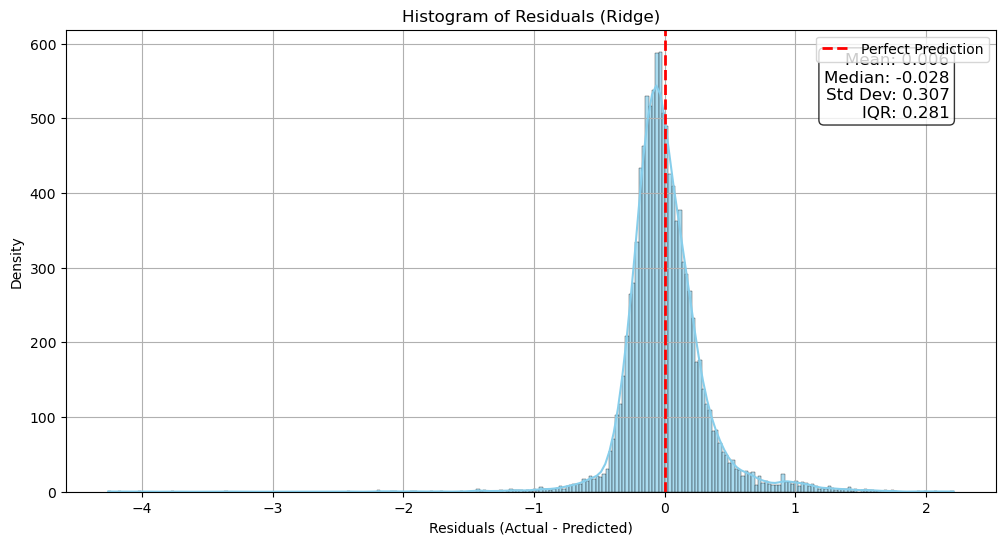

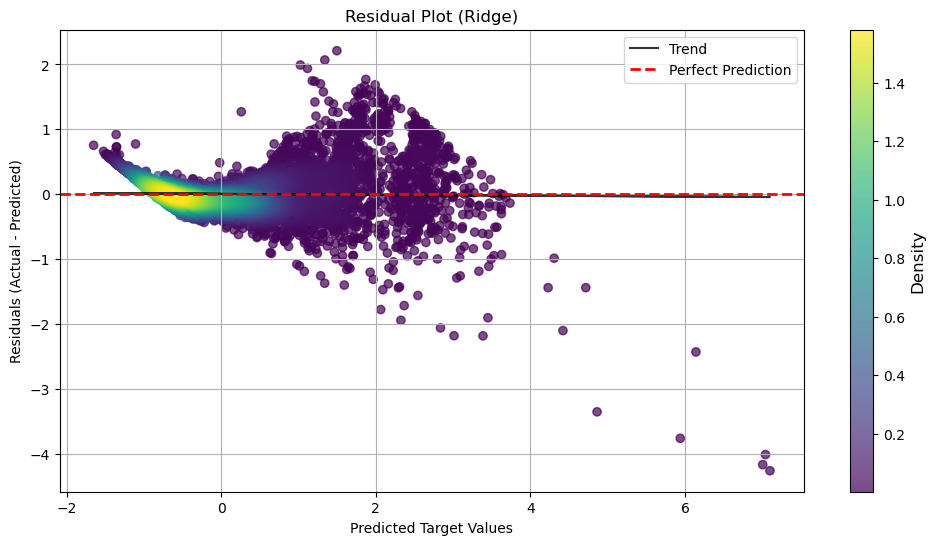

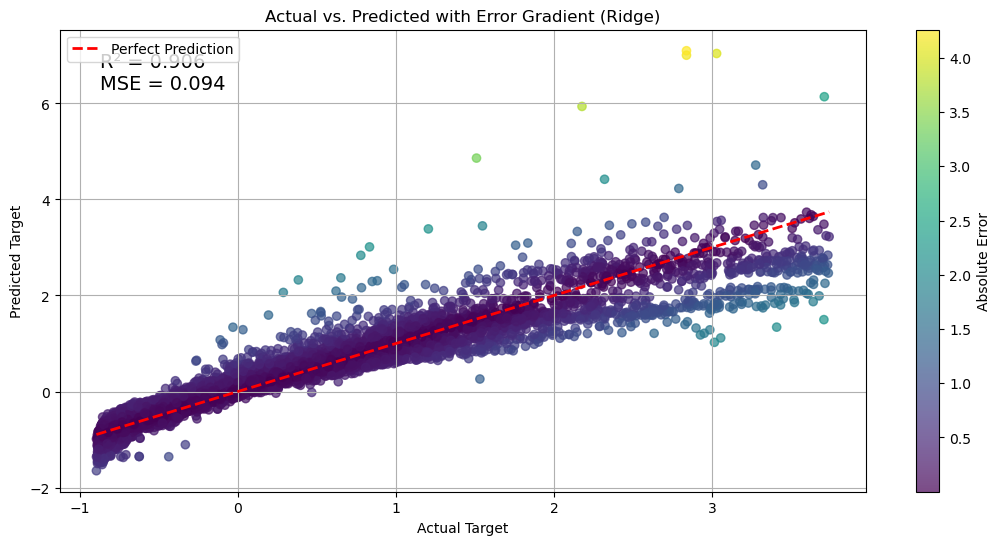

In [269]:
ridge_model_name: str = "Ridge"

ridge_y_train_predictions = model_results[ridge_model_name]["y_train_predictions"]
ridge_y_test_predictions = model_results[ridge_model_name]["y_test_predictions"]
ridge_residuals = y_test - ridge_y_test_predictions


display_model_evaluation_results(ridge_model_name)
plot_residuals_histogram(ridge_model_name, ridge_residuals)
plot_residuals_scatter(ridge_model_name, ridge_y_test_predictions, ridge_residuals)
plot_actual_vs_predicted(ridge_model_name, y_test, ridge_y_test_predictions)

### **Random Forest Model**

### **Model: Random Forest**

* #### **Train MSE:** 0.0025053

* #### **Test MSE:** 0.0184315

* #### **Test MAE:** 0.0676876

* #### **Test R^2:** 0.9815685

* #### **Test Adjusted R^2:** 0.9815531

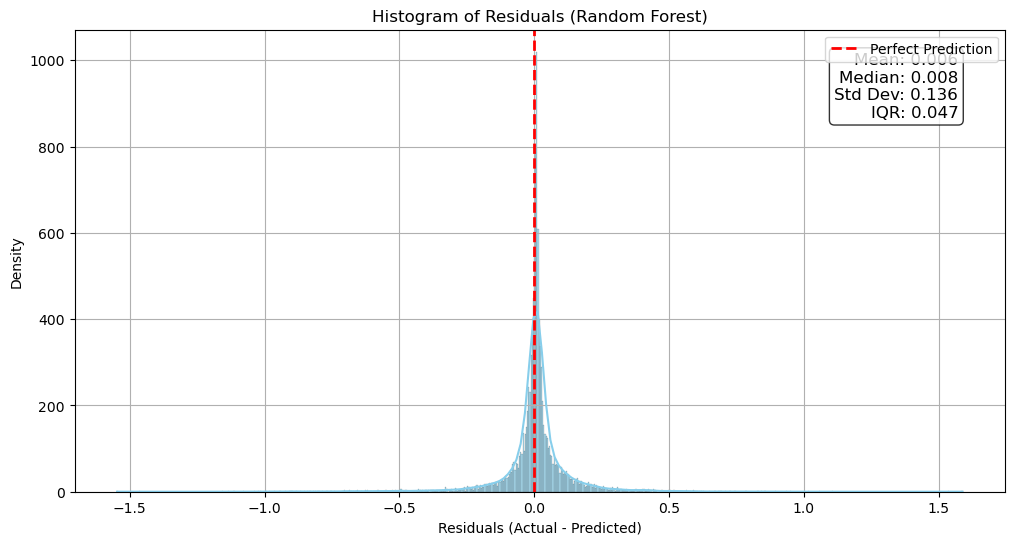

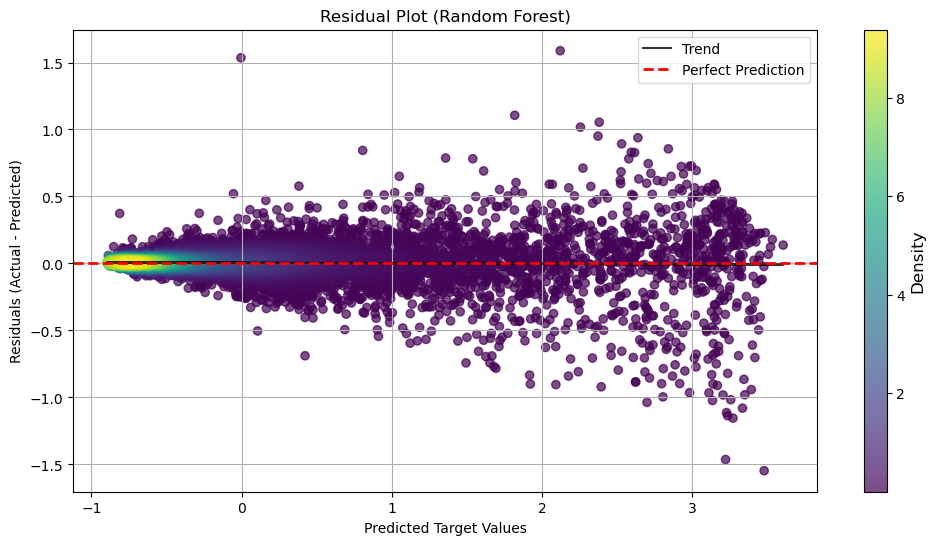

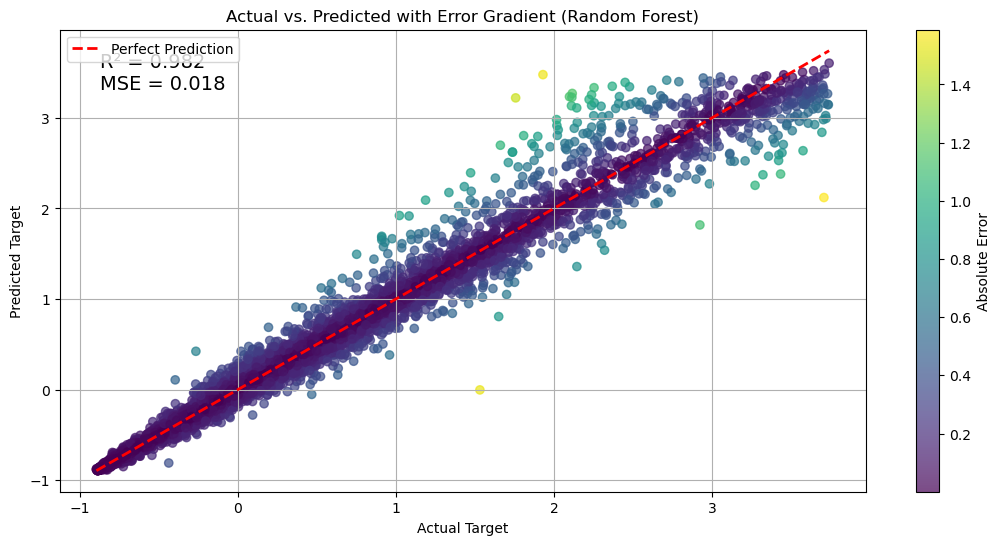

In [270]:
random_forest_model_name: str = "Random Forest"

random_forest_y_train_predictions = model_results[random_forest_model_name]["y_train_predictions"]
random_forest_y_test_predictions = model_results[random_forest_model_name]["y_test_predictions"]
random_forest_residuals = y_test - random_forest_y_test_predictions


display_model_evaluation_results(random_forest_model_name)
plot_residuals_histogram(random_forest_model_name, random_forest_residuals)
plot_residuals_scatter(random_forest_model_name, random_forest_y_test_predictions, random_forest_residuals)
plot_actual_vs_predicted(random_forest_model_name, y_test, random_forest_y_test_predictions)

### **Support Vector Model**

### **Model: SVR**

* #### **Train MSE:** 0.0201211

* #### **Test MSE:** 0.0208902

* #### **Test MAE:** 0.0823540

* #### **Test R^2:** 0.9791098

* #### **Test Adjusted R^2:** 0.9790923

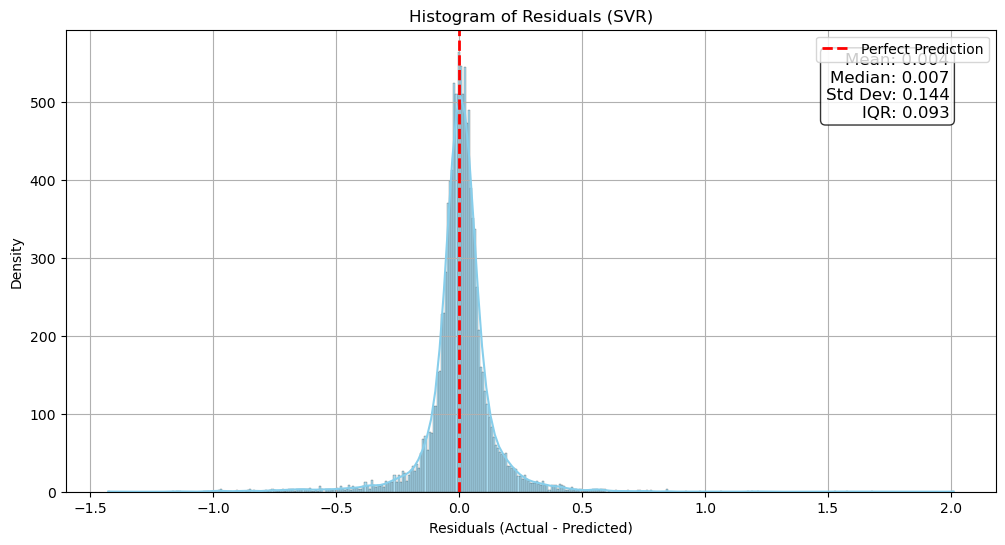

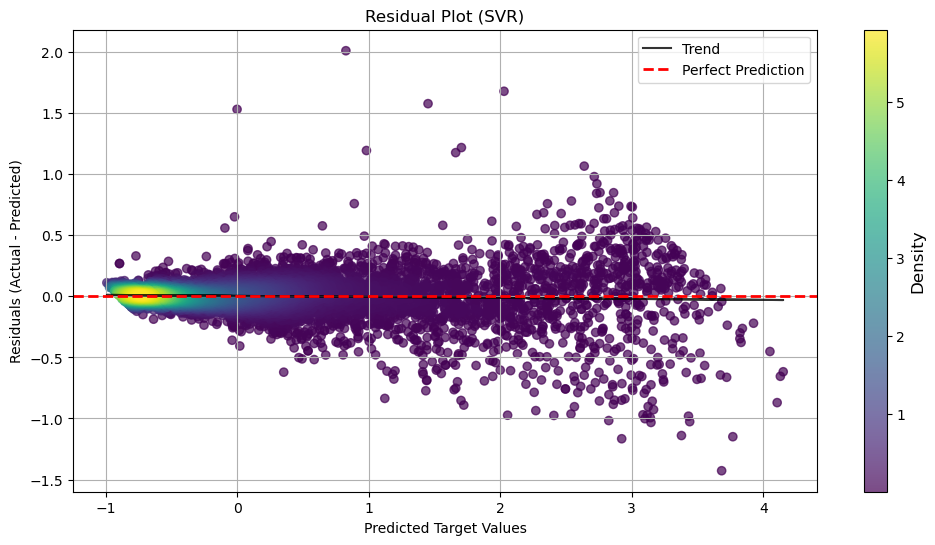

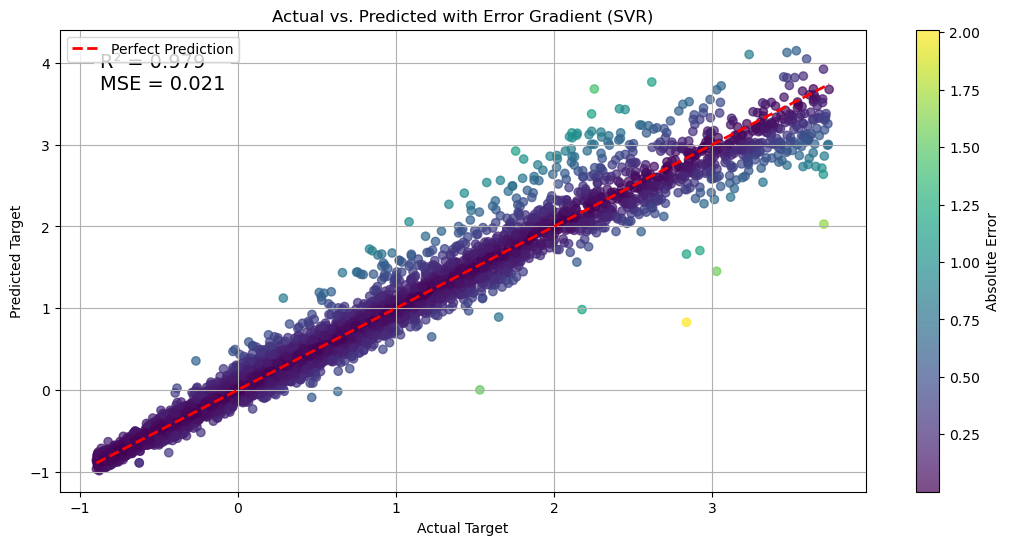

In [271]:
svr_model_name: str = "SVR"

svr_y_train_predictions = model_results[svr_model_name]["y_train_predictions"]
svr_y_test_predictions = model_results[svr_model_name]["y_test_predictions"]
svr_residuals = y_test - svr_y_test_predictions

display_model_evaluation_results(svr_model_name)
plot_residuals_histogram(svr_model_name, svr_residuals)
plot_residuals_scatter(svr_model_name, svr_y_test_predictions, svr_residuals)
plot_actual_vs_predicted(svr_model_name, y_test, svr_y_test_predictions)

## **Save Best Model**

In [21]:
save_file_name: str = "diamond_price_regression_model.pkl"

def save_model_pickle(file_name: str = save_file_name, model_name: str = best_model, results: dict[str, dict] = model_results) -> None:
    """
    Saves the best performing model to a pickle file.
    
    Args:
        file_name (str): Name of the pickle file to save the model to
        model_name (str): Name of the model that is about to be saved
        results (dict[str, dict]): Dictionary containing the model object, predictions on the testing data, and other model perfomance data
    Returns:
        None
    """
    with open(file_name, 'wb') as file:
        pickle.dump(results[model_name], file)
        

def save_model_joblib(file_name: str, model_name: str = best_model, results: dict[str, dict] = model_results) -> None:
    """
    Saves the best performing model to a joblib file.
    
    Args:
        file_name (str): Name of the joblib file to save the model to
        model_name (str): Name of the model that is about to be saved
        results (dict[str, dict]): Dictionary containing the model object, predictions on the testing data, and other model perfomance data
    Returns:
        None
    """
    dump(results[model_name], file_name)